# Analysis of Themes, Emotions and Tones in the Dataset

## 1. Introduction - TODO

## 2. Environment and Data

In [59]:
# import necessary libraries
import pandas as pd
import numpy as np
import spacy
from pathlib import Path
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm  
import seaborn as sns 
tqdm.pandas()

In [2]:
# set base repository path
REPO_DIR = Path(".").resolve().parents[1]
PROCESSED_DIR = REPO_DIR / "data" / "processed"

# define data input/output paths
PROCESSED_PATH = REPO_DIR / "data" / "processed" / "processed_book_chunks.csv"
PROCESSED_PATH_CONTEXT = REPO_DIR / "data" / "processed" / "processed_book_chunks_context.csv"  # for context-aware processing
EMOTION_EXPORT_PATH = REPO_DIR / "data" / "processed" / "emotion_sentences.csv"
THEME_EXPORT_PATH = REPO_DIR / "data" / "processed" / "thematic_corpus.csv"

# load spaCy model (can be switched later to transformer-based)
nlp = spacy.load("en_core_web_sm")  # light and fast for prototyping

# confirm setup
print("Repository Path:", REPO_DIR)
print("Processed Data Loaded From:", PROCESSED_PATH)

/Users/emmamora/anaconda3/envs/feminist-nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Repository Path: /Users/emmamora/Documents/GitHub/feminist_nlp
Processed Data Loaded From: /Users/emmamora/Documents/GitHub/feminist_nlp/data/processed/processed_book_chunks.csv


## 3. Load Source Data

we go over the data we are working with:
- full books stored in data/raw

In [3]:
# load the processed chunk-level dataframes (simple & context-aware)
df = pd.read_csv(PROCESSED_PATH)
df_context = pd.read_csv(PROCESSED_PATH_CONTEXT)


In [4]:
# basic structure check
print("-- Simple Dataframe --")
print("\nData shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head(5)

-- Simple Dataframe --

Data shape: (4852, 5)

Columns: ['chunk', 'title', 'author', 'year', 'chunk_id']


,chunk,title,author,year,chunk_id
0,CHAPTER 1.\nA Not Unnatural Enterprise This is...,Herland,Charlotte Perkins Gilman,1915,CP_001
1,The expedition was up among the thousand tribu...,Herland,Charlotte Perkins Gilman,1915,CP_002
2,It was early yet; we had just breakfasted; and...,Herland,Charlotte Perkins Gilman,1915,CP_003
3,“Woman Country--up\nthere.” Then we were inter...,Herland,Charlotte Perkins Gilman,1915,CP_004
4,"It had a special covering of fitted armor, thi...",Herland,Charlotte Perkins Gilman,1915,CP_005


In [5]:
print('-- Context-Aware Dataframe --')
print("\nData shape:", df_context.shape)
print("\nColumns:", df_context.columns.tolist())
df_context.head(5)

-- Context-Aware Dataframe --

Data shape: (5407, 5)

Columns: ['chunk', 'title', 'author', 'year', 'chunk_id']


,chunk,title,author,year,chunk_id
0,CHAPTER 1.\nA Not Unnatural Enterprise This is...,Herland,Charlotte Perkins Gilman,1915,CP_001
1,few things that don’t. We three had a chance t...,Herland,Charlotte Perkins Gilman,1915,CP_002
2,"I had understood, so I showed him a red and bl...",Herland,Charlotte Perkins Gilman,1915,CP_003
3,glass and squatted down to investigate. “Chemi...,Herland,Charlotte Perkins Gilman,1915,CP_004
4,a dozen Montenegroes up and down these great r...,Herland,Charlotte Perkins Gilman,1915,CP_005


We have 555 extra chunks in the context-aware version due to the fixed overlap of 50 words. In some cases, this is useful, in other not, that's why we created 2 different datasets.

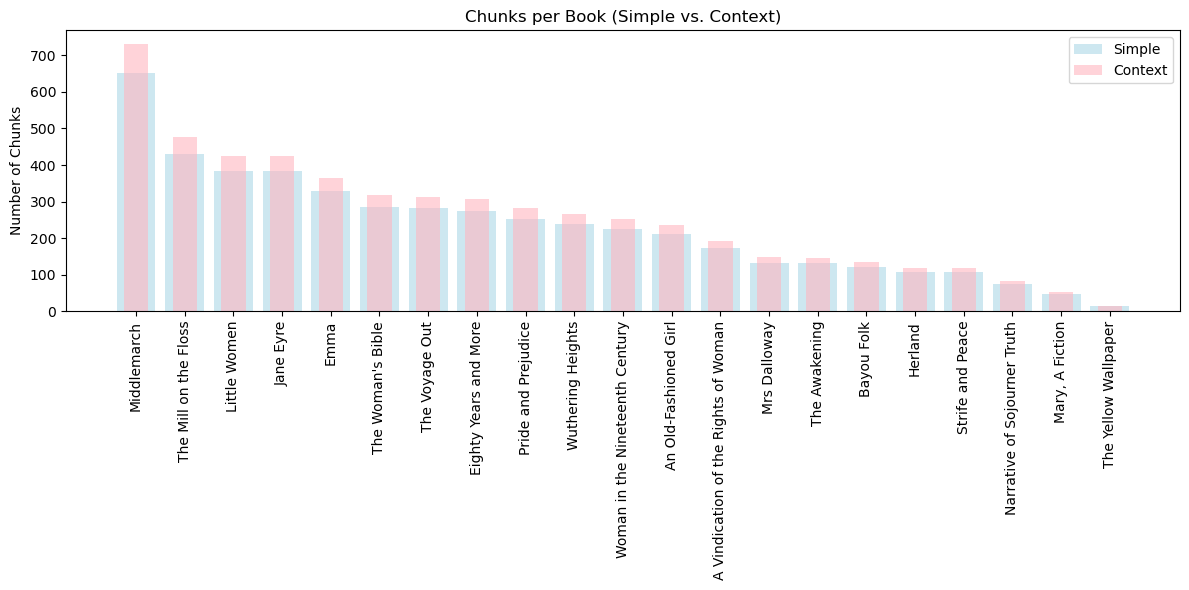

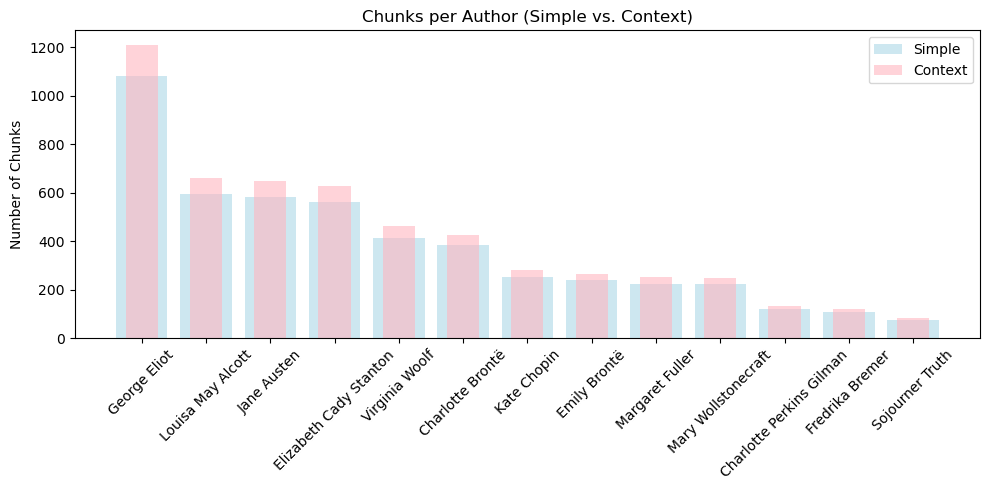

In [6]:
# compare chunk distribution

# group chunk counts by book
book_counts_simple = df["title"].value_counts().sort_values(ascending=False)
book_counts_context = df_context["title"].value_counts().reindex(book_counts_simple.index)

# group chunk counts by author
author_counts_simple = df["author"].value_counts().sort_values(ascending=False)
author_counts_context = df_context["author"].value_counts().reindex(author_counts_simple.index)

# plot: chunks per book (simple vs. context)
plt.figure(figsize=(12, 6))
plt.bar(book_counts_simple.index, book_counts_simple.values, alpha=0.6, label="Simple", color='lightblue')
plt.bar(book_counts_context.index, book_counts_context.values, alpha=0.6, label="Context", width=0.5, color='lightpink')
plt.xticks(rotation=90)
plt.ylabel("Number of Chunks")
plt.title("Chunks per Book (Simple vs. Context)")
plt.legend()
plt.tight_layout()
plt.show()

# plot: chunks per author (simple vs. context)
plt.figure(figsize=(10, 5))
plt.bar(author_counts_simple.index, author_counts_simple.values, alpha=0.6, label="Simple", color='lightblue')
plt.bar(author_counts_context.index, author_counts_context.values, alpha=0.6, label="Context", width=0.5, color='lightpink')
plt.xticks(rotation=45)
plt.ylabel("Number of Chunks")
plt.title("Chunks per Author (Simple vs. Context)")
plt.legend()
plt.tight_layout()
plt.show()

**Chunks per Book:**
Books like Middlemarch and The Mill on the Floss have the most chunks, reflecting their length. The context version consistently has more chunks due to overlapping windows, confirming that logic is working correctly.

**Chunks per Author:**
George Eliot, Louisa May Alcott, and Jane Austen lead in chunk volume. The consistent increase in context-based chunks across all authors further validates the overlap implementation.

These patterns provide a solid baseline for normalizing downstream thematic and emotional analyses. They also help contextualize our analysis by allowing us to normalize results—like emotion or theme frequency—relative to text length or author output.

## 4. Further Preprocessing

We'll prepare two versions of the data:
1.	A chunk-level, lemmatized and cleaned corpus for theme modeling (LDA, TF-IDF, BERTopic).
2.	A sentence-level, gender-filtered dataset for emotion classification (GoEmotions/BERT).

### 4.1 Preprocessing for Thematic Modeling

Goal: Detect themes like marriage, independence, and work.

Use: processed_book_chunks_context.csv (with overlap)

Why: Overlapping context (~50 words) provides continuity for LDA or BERTopic, which rely on broader textual context for coherent topics.

Preprocessing Plan:
- Lemmatize & remove stopwords/punctuation
- Detect collocations (e.g., “get married”, “go to work”)
- Prepare TF-IDF matrix or BERTopic input
- Create per-book or per-decade thematic models
- Optionally KWIC extract for target terms

In [7]:
# preview structure
df_context[["title", "chunk"]].head(3)

,title,chunk
0,Herland,CHAPTER 1.\nA Not Unnatural Enterprise This is...
1,Herland,few things that don’t. We three had a chance t...
2,Herland,"I had understood, so I showed him a red and bl..."


#### Lemmatization

In [8]:
# define a function to clean and lemmatize each chunk using spaCy
## lowercase, remove stop words, and lemmatize
def clean_and_lemmatize(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

In [9]:
tqdm.pandas()  # enable progress_apply for pandas

# apply lemmatization across all chunks
df_context["lemmatized_text"] = df_context["chunk"].progress_apply(clean_and_lemmatize)

100%|██████████| 5407/5407 [05:46<00:00, 15.58it/s]


In [10]:
# check lemmatization results
print("\nLemmatization Results Sample:")
print(df_context[["chunk", "lemmatized_text"]].head(5))

# deeper check of lemmatization
df_context["lemmatized_text"].head(10)


Lemmatization Results Sample:
                                               chunk  \
0  CHAPTER 1.\nA Not Unnatural Enterprise This is...   
1  few things that don’t. We three had a chance t...   
2  I had understood, so I showed him a red and bl...   
3  glass and squatted down to investigate. “Chemi...   
4  a dozen Montenegroes up and down these great r...   

                                     lemmatized_text  
0  chapter unnatural enterprise write memory unfo...  
1  thing chance join big scientific expedition ne...  
2  understand show red blue pencil carry ask yes ...  
3  glass squat investigate chemical sort tell spo...  
4  dozen montenegroe great range discuss hotly wa...  


0    chapter unnatural enterprise write memory unfo...
1    thing chance join big scientific expedition ne...
2    understand show red blue pencil carry ask yes ...
3    glass squat investigate chemical sort tell spo...
4    dozen montenegroe great range discuss hotly wa...
5    cliff waterfall yes ask jeff way course valuab...
6    find extremely clear idea country woman like u...
7    friend terry idea pretty woman game homely one...
8    triangle good speed cross base leave high moun...
9    hold peace long run upward gosh say terry woma...
Name: lemmatized_text, dtype: object

#### Detect and Inject Collocations

Collocations like "get married" or "go to school" carry thematic meaning that single tokens can’t capture. They’re especially helpful for:
- LDA & BERTopic, which treat each token as a potential topic signal.
- TF-IDF, where multi-word units can emerge as high-value terms.

We'll use only bigrams (2-word phrases), as they are simple, avoid overfitting and are relevant enough for our themes related to feminism.

In [11]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# find collocations in all lemmatized text
all_words = " ".join(df_context["lemmatized_text"]).split()
# find statitscally significant bigrams
finder = BigramCollocationFinder.from_words(all_words)

# set a minimum frequency threshold (5 appearances)
finder.apply_freq_filter(7)  # only keep bigrams that appear at least 5 times (eliminates rare but statistically significant bigrams)

# apply pointwise mutual information (PMI) to filter bigrams
top_bigrams = finder.nbest(BigramAssocMeasures.pmi, 500)

# convert to set for easy use
top_bigrams_set = set(["_".join(pair) for pair in top_bigrams])

In [12]:
# see top bigrams
print("Top 20 bigrams:")
for bigram in list(top_bigrams_set)[:20]:
    print("-", bigram)

Top 20 bigrams:
- tête_à
- wuthere_height
- miss_mayblunt
- straw_hat
- allen_chapter
- chapter_xxii
- pace_deck
- pocket_knife
- shalt_thou
- louisa_southworth
- game_chess
- miss_crocker
- thou_dost
- solar_system
- père_antoine
- anti_slavery
- gracechurch_street
- chapter_xxiii
- à_tête
- chapter_xii


In [13]:
def apply_collocations(text, bigrams_set):
    words = text.split()
    i = 0
    result = []
    while i < len(words) - 1:
        pair = f"{words[i]}_{words[i+1]}"
        if pair in bigrams_set:
            result.append(pair)
            i += 2
        else:
            result.append(words[i])
            i += 1
    if i == len(words) - 1:
        result.append(words[-1])
    return " ".join(result)

# apply to your text
df_context["lemmatized_text"] = df_context["lemmatized_text"].apply(lambda x: apply_collocations(x, top_bigrams_set))

Lower-frequency bigrams proved to be very bad in terms of interpretation. Instead, we see that after a frequency of 40 appearances, the quality improves. We will try to improve this even more using verb-based patterns, that will give us better collocations.

In [14]:
def extract_verb_phrases(text):
    doc = nlp(text)
    phrases = []
    for token in doc:
        if token.pos_ == "VERB":
            for child in token.children:
                if child.dep_ in ("dobj", "prep"):  # direct object or preposition
                    phrases.append(f"{token.lemma_}_{child.lemma_}")
    return phrases

df_context["verb_phrases"] = df_context["chunk"].progress_apply(extract_verb_phrases)

100%|██████████| 5407/5407 [05:50<00:00, 15.43it/s]


In [15]:
# preview updated text with bigrams
print("\nExample lemmatized text with bigrams:")
print(df_context["lemmatized_text"].iloc[0][:500])

# preview extracted verb-object/prep patterns
print("\nExample verb phrases:")
print(df_context["verb_phrases"].iloc[0][:20])


Example lemmatized text with bigrams:
chapter unnatural enterprise write memory unfortunately bring material carefully prepare different story book note carefully copy record firsthand description picture bad loss eye city park lot lovely view street building outside gorgeous garden important woman believe look description good come woman good description get rest world need know country say fear self appoint missionary trader land greedy expansionist push want tell fare bad find begin way classmate friend terry nicholson old nick g

Example verb phrases:
['write_from', 'bring_with', 'bring_material', 'have_bird’', 'have_eye', 'come_to', 'know_about', 'take_it', 'take_upon', 'tell_they', 'tell_that', 'find_it', 'call_he', 'call_with', 'know_year', 'have_in', 'have_deal', 'have_in', 'make_kind', 'fill_in']


#### Filter based on Model Granularity

In [19]:
# per-book aggregation
book_docs = df_context.groupby("title")["lemmatized_text"].apply(" ".join).reset_index()

# per-author (optional)
author_docs = df_context.groupby("author")["lemmatized_text"].apply(" ".join).reset_index()

In [20]:
print("Book Docs Size: ", book_docs.shape)
book_docs["lemmatized_text"].head(3)

Book Docs Size:  (21, 2)


0    introduction consider historic page view live ...
1    chapter polly arrive time station tom come oh ...
2    account creole agreeable afternoon late autumn...
Name: lemmatized_text, dtype: object

In [21]:
print("Author Docs Size: ", author_docs.shape)
author_docs["lemmatized_text"].head(3)

Author Docs Size:  (13, 2)


0    chapter possibility take walk day wander leafl...
1    chapter unnatural enterprise write memory unfo...
2    comment genesis exodus leviticus number deuter...
Name: lemmatized_text, dtype: object

#### Save Processed Corpora for Modeling

In [22]:
# for topic modeling (bigram + verb phrase extraction included)
df_context.to_csv(PROCESSED_DIR/ "thematic_chunks_context_bigram.csv", index=False)

# for per-book LDA/BERTOPIC
book_docs.to_csv(PROCESSED_DIR / "thematic_books.csv", index=False)

# for per-author LDA/BERTOPIC
author_docs.to_csv(PROCESSED_DIR / "thematic_authors.csv", index=False)

### 4.2 Preprocessing for Emotion Classification

This section prepares the cleaned and chunked text data for two types of classification tasks: sentence-level emotion detection and chunk-level tone analysis. These preprocessing steps ensure our models operate on well-structured, targeted inputs aligned with each task’s scope.

#### Chunk-Level Tone Classification (Processed Chunks)

**Goal:** Classify each book chunk into a tone category (e.g., neutral, hopeful, bleak, tense).

**Why:** Tone classification benefits from broader context and is better suited for ~500 word-level sections rather than isolated sentences.

**Steps:**
- Load the processed dataset (`processed_book_chunks.csv`) containing non-overlapping, clean 500-word chunks.
- Create a new column `inferred_tone`, to be filled later by a classifier or manual annotation.
- This structure enables downstream tone classification or evaluation.

**Output:**
- `tone_chunks.csv` (saved in `data/processed/`)


In [101]:
# load the dataset into a DataFrame
df_chunks = pd.read_csv(PROCESSED_PATH)

# preview the first few rows
df_chunks.head()

,chunk,title,author,year,chunk_id
0,CHAPTER 1.\nA Not Unnatural Enterprise This is...,Herland,Charlotte Perkins Gilman,1915,CP_001
1,The expedition was up among the thousand tribu...,Herland,Charlotte Perkins Gilman,1915,CP_002
2,It was early yet; we had just breakfasted; and...,Herland,Charlotte Perkins Gilman,1915,CP_003
3,“Woman Country--up\nthere.” Then we were inter...,Herland,Charlotte Perkins Gilman,1915,CP_004
4,"It had a special covering of fitted armor, thi...",Herland,Charlotte Perkins Gilman,1915,CP_005


In [102]:
# create an empty column for tone classification to be filled later
df_chunks["inferred_tone"] = ""

# save to CSV
df_chunks.to_csv(str(PROCESSED_DIR / "tone_chunks.csv"), index=False)

#### Sentence-Level Emotion Classification (Gendered Sentences)

**Goal:** Identify emotions (e.g., anger, joy, fear) in individual sentences that reference women or femininity.

**Why:** Focusing on gendered references allows us to study how emotions are linguistically expressed around female characters or roles.

**Steps:**
- Load and segment chunks into individual sentences using `spaCy`.
- Filter for sentences that contain gendered terms (e.g., “she”, “wife”, “mother”) or historically feminine names (e.g., “Jo”, “Emma”, “Dorothea”).
- Remove sentences shorter than 5 words for quality control.
- Retain metadata (book title, author, year, chunk_id) with each sentence.
- Add an `inferred_emotion` column as a placeholder for future labeling.

**Output:**
- `emotion_sentences.csv` (saved in `data/processed/`)

**Note:** The gendered lexicon is tailored for 18th–20th century literature, combining role-based vocabulary and character name frequencies derived from our dataset.

In [79]:
# load spaCy English model
nlp = spacy.load("en_core_web_sm")

# load the cleaned, chunked data without overlaps
df_chunks = pd.read_csv(PROCESSED_DIR / "processed_book_chunks.csv")

# quick sanity check
print(f"Loaded {len(df_chunks)} chunks")
df_chunks.head()

Loaded 4852 chunks


,chunk,title,author,year,chunk_id
0,CHAPTER 1.\nA Not Unnatural Enterprise This is...,Herland,Charlotte Perkins Gilman,1915,CP_001
1,The expedition was up among the thousand tribu...,Herland,Charlotte Perkins Gilman,1915,CP_002
2,It was early yet; we had just breakfasted; and...,Herland,Charlotte Perkins Gilman,1915,CP_003
3,“Woman Country--up\nthere.” Then we were inter...,Herland,Charlotte Perkins Gilman,1915,CP_004
4,"It had a special covering of fitted armor, thi...",Herland,Charlotte Perkins Gilman,1915,CP_005


In [80]:
tqdm.pandas()  

# function that segments text into sentences
def split_chunk_into_sentences(chunk):
    doc = nlp(chunk)
    return [sent.text.strip() for sent in doc.sents if sent.text.strip()]

# create a list of rows, one per sentence
all_sentences = []

# loop over all chunks with progress bar
for _, row in tqdm(df_chunks.iterrows(), total=len(df_chunks), desc="Splitting sentences"):
    sentences = split_chunk_into_sentences(row["chunk"])
    for sent in sentences:
        all_sentences.append({
            "sentence": sent,
            "title": row["title"],
            "author": row["author"],
            "year": row["year"],
            "chunk_id": row["chunk_id"]
        })

Splitting sentences: 100%|██████████| 4852/4852 [05:18<00:00, 15.21it/s]


In [81]:
# convert to DataFrame
df_sentences = pd.DataFrame(all_sentences)

# check result
print(f"Extracted {len(df_sentences)} sentences from {len(df_chunks)} chunks")
df_sentences.sample(5)

Extracted 114207 sentences from 4852 chunks


,sentence,title,author,year,chunk_id
77243,"He gave a short laugh, shook\nhands with her, ...",Little Women,Louisa May Alcott,1868,LM_041
71548,"No, no,\nyou shall not deceive me: I know it t...",Pride and Prejudice,Jane Austen,1813,JA_243
22817,"They rove about, mental and moral\nIshmaelites...",Woman in the Nineteenth Century,Margaret Fuller,1845,MF_050
103864,"Turning, she gazed in through the gaping chasm...",Bayou Folk,Kate Chopin,1894,KC_097
110477,"“You know I am a scoundrel, Jane?”",Jane Eyre,Charlotte Brontë,1847,CB_250


In [90]:
# list of historically common feminine-coded words (1790-1925)
GENDERED_TERMS = [
    # pronouns
    "she", "her", "hers", "herself",
    # gender terms
    "woman", "women", "female",
    # titles
    "lady", "ladies", "miss", "missus", "madam", "ma'am",
    "mistress", "matron", "dame", "spinster", "widow",
    # family
    "mother", "mom", "mama", "mamma", "mum",
    "daughter", "sister", "aunt", "niece",
    "wife", "bride", "widow", "matron",
    # youth
    "girl", "girls", "maiden", "lass", "lassie", "belle",
    # ocupations and roles
    "governess", "nursemaid", "seamstress", "maid", "housekeeper",
    "servant", "companion", "chaperone", "schoolmistress",
    # religious and cultural references
    "nun", "virgin", "mother superior", "abbess",
    # terms of address or description
    "gentlewoman", "fair one", "damsel", "lady love", "coquette",
    "biddy", "wench", "heroine"
]

# taken from character list (see section 5.4)
FEMALE_NAMES = [
    "jo", "dorothea", "emma", "jane", "elizabeth", "mary", "amy", "maggie",
    "susanna", "rachel", "beth", "harriet", "lucy", "catherine", "meg",
    "isabella", "rosamond", "hannah", "helen", "susan", "sally", "cathy",
    "lizzy", "ellen", "evelyn", "kitty", "miss bates", "diana", "bessie",
    "lady catherine", "miss", "astrid", "clarissa", "jane fairfax"
]

In [91]:
# lowercase everything for case-insensitive matching
df_sentences["sentence_lower"] = df_sentences["sentence"].str.lower()

# merge the lists for matching
gender_indicators = GENDERED_TERMS + FEMALE_NAMES

# build a regex pattern using word boundaries for exact matches
pattern = r'\b(' + '|'.join(re.escape(term) for term in gender_indicators) + r')\b'

# apply regex to filter sentences that include any gendered term or female name
df_gendered = df_sentences[df_sentences["sentence_lower"].str.contains(pattern, regex=True)]

# drop helper column after filtering
df_gendered = df_gendered.drop(columns=["sentence_lower"])

# summary
print(f"{len(df_gendered)} sentences matched gendered terms or names (out of {len(df_sentences)} total)")

45778 sentences matched gendered terms or names (out of 114207 total)


In [92]:
# remove sentences under 5 words (optional threshold)
df_gendered["word_count"] = df_gendered["sentence"].str.split().str.len()
df_filtered = df_gendered[df_gendered["word_count"] >= 5].copy()

print(f"Remaining after length filter: {len(df_filtered)}")
df_filtered.drop(columns=["word_count"], inplace=True)

Remaining after length filter: 44264


In [98]:
# placeholder label column
df_filtered["inferred_emotion"] = ""

# columns: sentence, label, title, author, year, chunk_id
df_filtered.head()

,sentence,title,author,year,chunk_id,inferred_emotion
4,We had some\nbird’s-eyes of the cities and par...,Herland,Charlotte Perkins Gilman,1915,CP_001,
6,Descriptions aren’t any good\nwhen it comes to...,Herland,Charlotte Perkins Gilman,1915,CP_001,
35,"And as we got farther and farther upstream, in...",Herland,Charlotte Perkins Gilman,1915,CP_002,
36,"“Up yonder,” “Over there,” “Way up”--was all t...",Herland,Charlotte Perkins Gilman,1915,CP_002,
39,"But there were tales of long ago, when some br...",Herland,Charlotte Perkins Gilman,1915,CP_002,


In [100]:
df_filtered.to_csv(str(PROCESSED_DIR / "emotion_sentences.csv"), index=False)
print(f"Saved gendered emotional sentences)

Saved gendered emotional sentences to: /Users/emmamora/Documents/GitHub/feminist_nlp/data/processed/processed_book_chunks.csv


## 5. Thematic Modeling

### 5.1 TF-IDF Term Extraction

**Goal:** Identify the most thematically relevant terms used in each book or by each author.

TF-IDF (Term Frequency–Inverse Document Frequency) is used to highlight words that are particularly important to one document (e.g., book or author) relative to others in the corpus.

**Why this matters:**
- Captures key vocabulary without being overwhelmed by common words.
- Can be used as input for further modeling (e.g., clustering).
- Helps surface themes like *marriage*, *education*, *freedom*, etc.

We’ll compute:
- TF-IDF on **lemmatized + bigrammed chunks**
- Aggregate terms **per book** and **per author**
- Extract top **n terms** per document

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# load pre-processed data
books_df = pd.read_csv(PROCESSED_DIR / "thematic_books.csv")
authors_df = pd.read_csv(PROCESSED_DIR / "thematic_authors.csv")

In [24]:
# define a TF-IDF vectorizer
# we include unigrams and bigrams (from preprocessed lemmatized_text)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)

In [25]:
# fit tf-idf on book texts
tfidf_books = vectorizer.fit_transform(books_df["lemmatized_text"])
tfidf_feature_names = vectorizer.get_feature_names_out()

# convert to dataframe for inspection
tfidf_books_df = pd.DataFrame(tfidf_books.toarray(), columns=tfidf_feature_names)
tfidf_books_df["title"] = books_df["title"]

In [26]:
tfidf_books_df.head(5)

,aaron,aback,abandon,abandon field,abandon scheme,abandon speculation,abandon tear,abandonment,abase,abasement,...,zest,zigzag,zillah,zion,zion haughty,zodiac,zone,zoo,zoological,à_la
0,0.000000,0.000000,0.003132,0.000000,0.0,0.000000,0.0,0.0,0.003228,0.002917,...,0.006128,0.000000,0.0,0.0,0.0,0.0,0.002314,0.0,0.000000,0.000000
1,0.000000,0.000558,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.014223,0.007328,0.0,0.003664,0.0,0.0,0.000000,0.000000,...,0.002319,0.002627,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.012154
3,0.005827,0.000000,0.004170,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.005440,0.001540,0.0,0.0,0.0,0.0,0.001540,0.0,0.002149,0.001782
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000649,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [27]:
def get_top_terms(tfidf_row, feature_names, top_n=10):
    top_indices = np.argsort(tfidf_row)[-top_n:]
    return [feature_names[i] for i in reversed(top_indices)]

books_df["top_terms"] = tfidf_books_df.drop(columns=["title"]).apply(
    lambda row: get_top_terms(row.values, tfidf_feature_names), axis=1
)
books_df[["title", "top_terms"]].head(5)

,title,top_terms
0,A Vindication of the Rights of Woman,"[sex, render, understand young, rousseau, fema..."
1,An Old-Fashioned Girl,"[polly, toll, fanny, maud, fan, shaw, grandma,..."
2,Bayou Folk,"[dat, de, yielding, bayou, la_folle, madame, y..."
3,Eighty Years and More,"[anthony, convention, suffrage, stanton, new_y..."
4,Emma,"[emma, westminster cathedral, harriet, woodenn..."


In [28]:
# fit tf-idf on author texts
tfidf_authors = vectorizer.fit_transform(authors_df["lemmatized_text"])
tfidf_authors_df = pd.DataFrame(tfidf_authors.toarray(), columns=vectorizer.get_feature_names_out())

# extract top terms per author
authors_df["top_terms"] = tfidf_authors_df.apply(
    lambda row: get_top_terms(row.values, vectorizer.get_feature_names_out()), axis=1
)
authors_df[["author", "top_terms"]].head(5)

,author,top_terms
0,Charlotte Brontë,"[rochester, jane, fairfax, adèle, mrs fairfax,..."
1,Charlotte Perkins Gilman,"[terry, motherhood, big, john, baby, civilizat..."
2,Elizabeth Cady Stanton,"[unto, bible, moses, israel, say unto, thy, th..."
3,Emily Brontë,"[catherine, edgar, joseph, nelly, wuthere_heig..."
4,Fredrika Bremer,"[susanna, norway, mountain, whilst, sweden, no..."


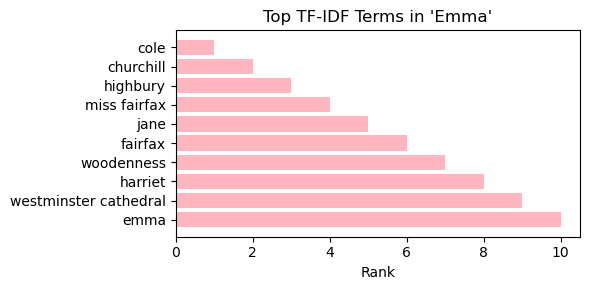

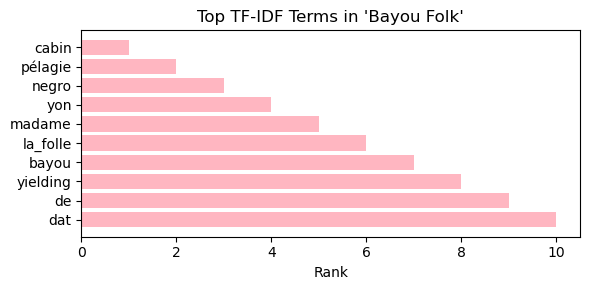

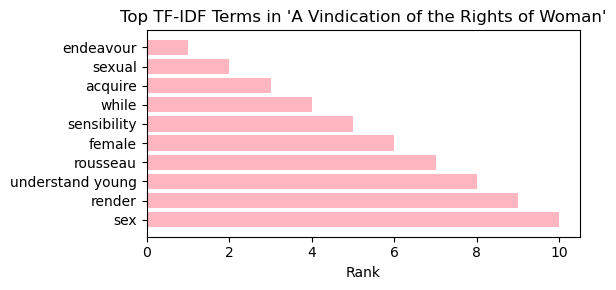

In [29]:
import matplotlib.pyplot as plt

# choose a few representative titles
selected_titles = ["Emma", "Bayou Folk", "A Vindication of the Rights of Woman"]

for title in selected_titles:
    top_terms = books_df[books_df["title"] == title]["top_terms"].values[0]
    plt.figure(figsize=(6, 3))
    plt.barh(top_terms[::-1], range(1, len(top_terms) + 1), color="lightpink")
    plt.title(f"Top TF-IDF Terms in '{title}'")
    plt.xlabel("Rank")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

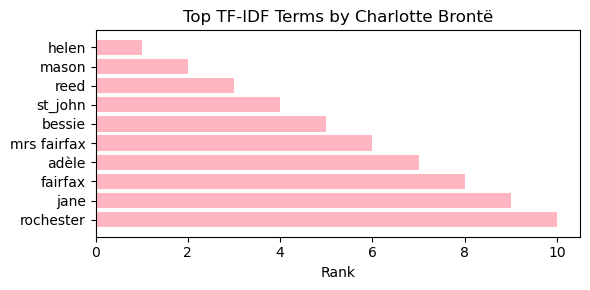

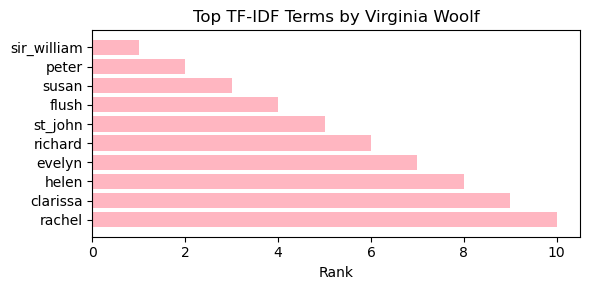

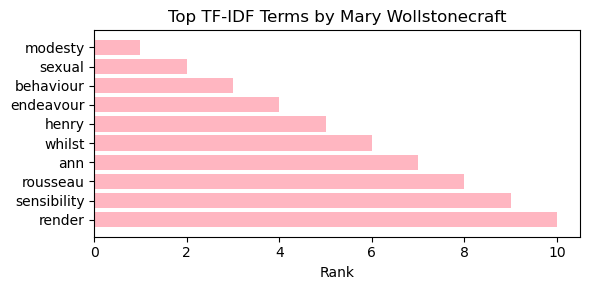

In [30]:
selected_authors = ["Charlotte Brontë", "Virginia Woolf", "Mary Wollstonecraft"]

for author in selected_authors:
    top_terms = authors_df[authors_df["author"] == author]["top_terms"].values[0]
    plt.figure(figsize=(6, 3))
    plt.barh(top_terms[::-1], range(1, len(top_terms) + 1), color="lightpink")
    plt.title(f"Top TF-IDF Terms by {author}")
    plt.xlabel("Rank")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### 5.2 LDA Topic Modeling

**Goal:** Uncover latent topics across books using unsupervised modeling.

LDA (Latent Dirichlet Allocation) discovers clusters of co-occurring words that often appear together in documents, which can be interpreted as themes.

**Why this matters:**
- Reveals deeper semantic structure than TF-IDF
- Allows comparison of thematic makeup across books or authors
- Serves as input for visualization and interpretation (pyLDAvis)

We will:
- Tokenize and prepare lemmatized + bigrammed texts
- Create a Gensim dictionary and corpus
- Train an LDA model
- Display top words per topic

In [31]:
import gensim

In [34]:
import gensim
from gensim import corpora, models

# load preprocessed data (chunk-level)

df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")

# use lemmatized + bigrammed text column
texts = df["lemmatized_text"].apply(lambda x: x.split()).tolist()

In [35]:
# build dictionary (word → id mapping)
dictionary = corpora.Dictionary(texts)

# filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)

# create bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in texts]

In [36]:
# train LDA model
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,         # you can tune this
    random_state=42,
    passes=10,
    per_word_topics=True
)

In [37]:
# print top terms for each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}:")
    print(topic)
    print()

Topic 1:
0.007*"room" + 0.006*"old" + 0.006*"stand" + 0.006*"day" + 0.005*"sit" + 0.005*"door" + 0.005*"hand" + 0.005*"see" + 0.005*"woman" + 0.004*"house"

Topic 2:
0.019*"mr" + 0.015*"fred" + 0.011*"mary" + 0.011*"mrs" + 0.011*"tell" + 0.010*"get" + 0.009*"o" + 0.009*"money" + 0.009*"father" + 0.009*"want"

Topic 3:
0.033*"mr" + 0.018*"lydgate" + 0.012*"mrs" + 0.010*"rosamond" + 0.010*"bulstrode" + 0.007*"thing" + 0.005*"feel" + 0.005*"celia" + 0.004*"vincy" + 0.004*"middlemarch"

Topic 4:
0.013*"woman" + 0.011*"mind" + 0.011*"susanna" + 0.009*"heart" + 0.009*"love" + 0.008*"virtue" + 0.008*"nature" + 0.007*"reason" + 0.006*"affection" + 0.006*"beauty"

Topic 5:
0.006*"life" + 0.005*"find" + 0.004*"feel" + 0.004*"year" + 0.004*"give" + 0.004*"woman" + 0.004*"mind" + 0.004*"friend" + 0.004*"day" + 0.004*"feeling"

Topic 6:
0.007*"love" + 0.007*"eye" + 0.006*"feel" + 0.006*"long" + 0.006*"hand" + 0.006*"life" + 0.005*"day" + 0.005*"see" + 0.005*"leave" + 0.005*"heart"

Topic 7:
0.015*"

Below is a high-level interpretation of the 10 LDA topics, based on their top words:

| **Topic** | **Top Words** | **Probable Theme** |
|-----------|---------------|---------------------|
| **1** | room, stand, door, sit, woman, house | **Domestic space & physical environment** — scenes of home life and interior detail |
| **2** | mr, fred, mary, mrs, money, father, want | **Family and financial dynamics** — interpersonal negotiation, desire, social position |
| **3** | mr, lydgate, rosamond, middlemarch, bulstrode | **Middlemarch-specific** — characters and themes from Eliot’s novel |
| **4** | woman, mind, love, virtue, affection, beauty | **Philosophy, inner life, and feminine virtue** — idealism, character, and emotion |
| **5** | life, feel, year, friend, give, day | **Reflection and connection** — passages about time, emotion, and relational ties |
| **6** | love, eye, see, hand, leave, heart | **Romantic and emotional intensity** — expressions of longing and closeness |
| **7** | jo, polly, girl, amy, tom, laurie, meg | **Girlhood and relationships** — characters from *Little Women*, *An Old-Fashioned Girl* |
| **8** | mr, mrs, maggie, jane, emma, miss, elizabeth | **Named female leads** — Austen/Brontë characters and their social surroundings |
| **9** | woman, child, god, wife, lord, mother | **Morality, religion, and womanhood** — sacred roles and societal expectations |
| **10** | dorothea, casaubon, brooke, husband, young | **Dorothea Brooke & marriage conflict** — specific to *Middlemarch*'s plot arc |

This interpretation helps inform future steps like:
- Comparing topic spread across authors or genres
- KWIC analysis of topic keywords
- Emotion overlay within specific themes

Some topics clearly align with specific books or characters (Dorothea in Middlemarch), while others reflect broader feminist themes like love, virtue, or motherhood - recurring across authors. This mix highlights how LDA captures both narrative identity and shared ideological ground.

In [38]:
# assign dominant topic per chunk
def get_dominant_topic(doc_bow):
    topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    topic_probs_sorted = sorted(topic_probs, key=lambda x: -x[1])
    return topic_probs_sorted[0][0], topic_probs_sorted[0][1]  # topic_id, probability

# apply to all chunks
topic_assignments = [get_dominant_topic(doc) for doc in corpus]
df["topic_id"] = [topic[0] for topic in topic_assignments]
df["topic_prob"] = [topic[1] for topic in topic_assignments]

In [39]:
# extract top words for each topic
topic_terms = {
    i: ", ".join([term.split("*")[1].strip().strip('"') 
                  for term in lda_model.print_topics(num_words=6)[i][1].split(" + ")])
    for i in range(lda_model.num_topics)
}

# map back to df
df["topic_label"] = df["topic_id"].map(topic_terms)

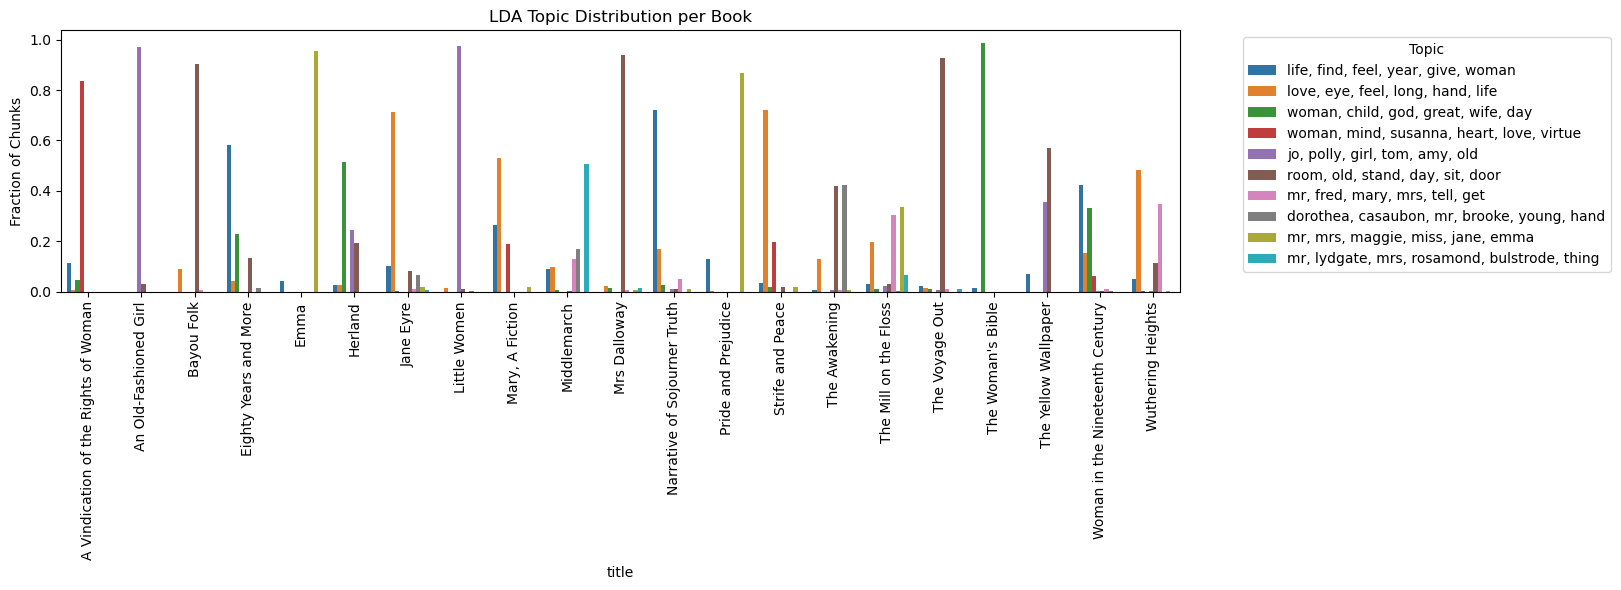

In [40]:
import seaborn as sns

# group by book and topic
topic_dist = df.groupby(["title", "topic_label"]).size().reset_index(name="count")

# normalize within each book
topic_dist["fraction"] = topic_dist.groupby("title")["count"].transform(lambda x: x / x.sum())

# plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=topic_dist,
    x="title", y="fraction", hue="topic_label"
)
plt.xticks(rotation=90)
plt.title("LDA Topic Distribution per Book")
plt.ylabel("Fraction of Chunks")
plt.tight_layout()
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This bar chart shows the proportion of text chunks in each book assigned to each LDA topic.

- Some books are **dominated by a single topic**, such as *A Vindication of the Rights of Woman* (philosophy/virtue), or *An Old-Fashioned Girl* (girlhood and domestic life).
- Others, like *Middlemarch* and *Eighty Years and More*, are **more thematically diverse**, reflecting broader narrative scope or ideological layering.
- Certain topics — especially those tied to character names — appear to be **book-specific**, while others recur across multiple texts, suggesting **shared thematic concerns** (e.g., love, reflection, womanhood).

This distribution helps reveal how literary form and feminist content interact differently across texts.

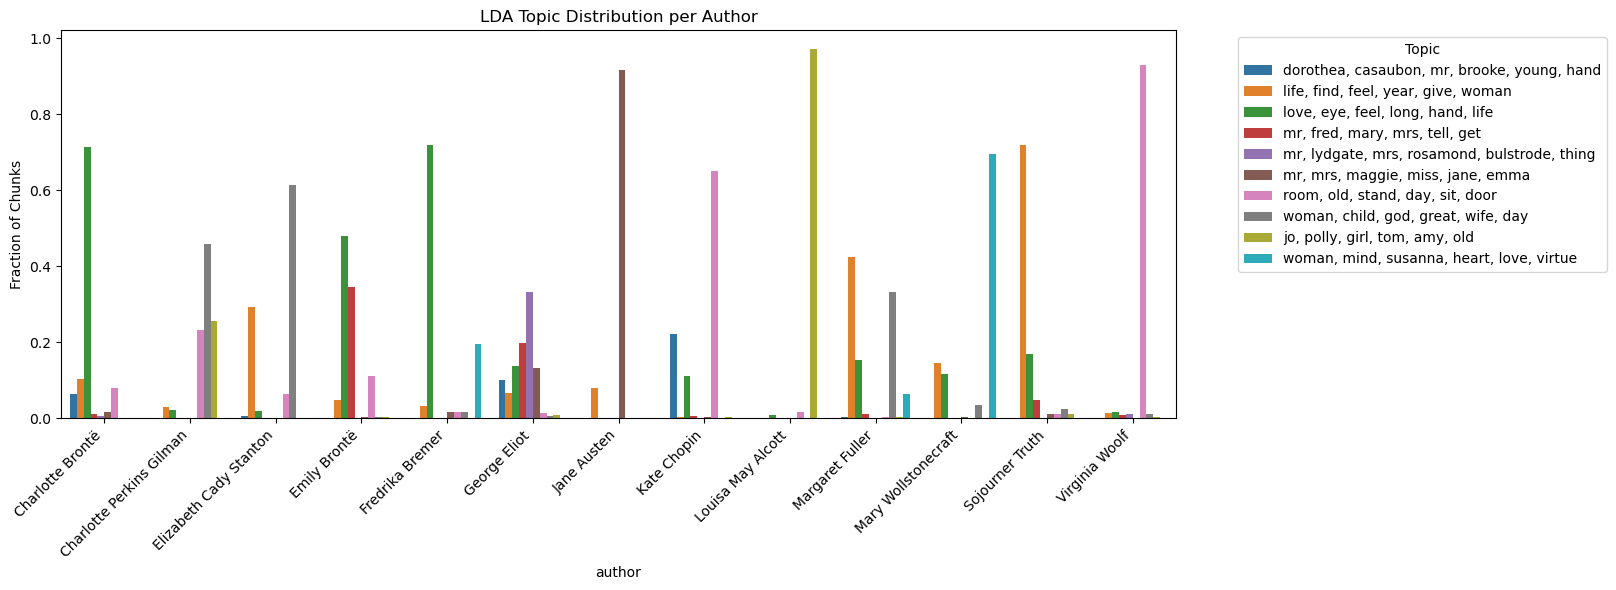

In [42]:
# group by author and topic
author_topic_dist = df.groupby(["author", "topic_label"]).size().reset_index(name="count")

# normalize within each author
author_topic_dist["fraction"] = author_topic_dist.groupby("author")["count"].transform(lambda x: x / x.sum())

# plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=author_topic_dist,
    x="author", y="fraction", hue="topic_label"
)
plt.xticks(rotation=45, ha="right")
plt.title("LDA Topic Distribution per Author")
plt.ylabel("Fraction of Chunks")
plt.tight_layout()
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This chart shows how each author's work is thematically distributed across the 10 learned LDA topics.

- **Some authors are strongly associated with a single topic**, such as Jane Austen (centered on character-driven relationships) or Louisa May Alcott (focused on girlhood and domestic life).
- Others like Elizabeth Cady Stanton or Mary Wollstonecraft engage **multiple topics**, reflecting a broader range of feminist concerns — from religion and womanhood to moral virtue and education.
- **Topic recurrence across authors** (emotion, love, virtue) reveals shared thematic ground in 19th-century feminist writing, while **topic exclusivity** (e.g., named characters or philosophical tone) reflects genre and narrative style differences.

This perspective highlights both individual authorial focus and collective thematic continuity across the corpus.

In [44]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# prepare pyLDAvis visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# show in notebook (or save if running outside)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.033878 -0.123169       1        1  14.557256
4     -0.107801  0.082531       2        1  13.202455
0      0.124510 -0.160547       3        1  13.134104
7      0.073259  0.092206       4        1  12.133098
6      0.086452 -0.056869       5        1  11.481785
8     -0.166097 -0.042746       6        1  11.212423
2      0.025873  0.123561       7        1   7.745779
1      0.112806  0.103663       8        1   6.469278
9      0.053565  0.016637       9        1   5.658722
3     -0.236445 -0.035268      10        1   4.405100, topic_info=           Term         Freq        Total Category  logprob  loglift
483          mr  7846.000000  7846.000000  Default  30.0000  30.0000
114       woman  5860.000000  5860.000000  Default  29.0000  29.0000
8582   dorothea  1404.000000  1404.000000  Default  28.0000  28.0000
12273        jo  1728.000000  1728.000000  Default  27.0000  27.0000
12394   lydgate  1338.000000  1338.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
654       sense   156.793235  1058.989969  Topic10  -5.6077   1.2123
437     society   137.248140   521.638854  Topic10  -5.7408   1.7872
1115       true   149.713693   907.495303  Topic10  -5.6539   1.3204
116       world   152.209241  1712.523445  Topic10  -5.6373   0.7019
559      mother   149.633520  2454.080412  Topic10  -5.6544   0.3251

[814 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
9864       9  0.975317         abbot
7423       2  0.950046  abolitionist
7116       6  0.991020       abraham
2686       1  0.018118       acquire
2686       2  0.060394       acquire
...      ...       ...           ...
372        8  0.073867         young
372        9  0.127696         young
372       10  0.043220         young
12560      1  0.013166       zoraïde
12560      3  0.974252       zoraïde

[2681 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 8, 7, 9, 3, 2, 10, 4])

This interactive visualization helps interpret topic models by plotting topics in a 2D space (via multidimensional scaling) and showing the top terms for each topic.

- **Topic separation**: Topics are well spread out, suggesting the model has learned distinct thematic clusters.
- **Topic prominence**: Circle sizes reflect how prevalent each topic is in the corpus. For instance, Topic 1 appears to be the most dominant, followed by Topics 2 and 3.
- **Term relevance**: The right-hand panel lists the top terms for a selected topic, helping interpret its thematic core (e.g. Topic 10 relates closely to *Middlemarch* via terms like "dorothea" and "casaubon").
- **Usefulness**: This view is particularly valuable for diagnosing overlap between topics or refining the number of topics (`num_topics`).

This visualization complements the per-book and per-author distributions by showing the semantic space of topics directly and interactively.

In [46]:
# create reports/figures folder if it doesn't exist
(REPO_DIR / "reports" / "figures").mkdir(parents=True, exist_ok=True)

pyLDAvis.save_html(vis, str(REPO_DIR / "reports" / "figures" / "lda_topics.html"))

### 5.3 Word Embedding Clustering


To explore latent semantic structure among thematic terms, we trained a Word2Vec model on the lemmatized + bigrammed text chunks.

**Training & Optimization**
- Used **Word2Vec** (vector size = 150, window = 7, min_count = 10, epochs = 30)
- Filtered out low-frequency and overly general words
- Clustered word vectors using **KMeans (k=10)**
- Projected embeddings to 2D using **UMAP** for clearer visual separation

**Visual & Semantic Interpretation**
The final UMAP projection showed distinct semantic groupings. Selected cluster interpretations include:

- **Cluster 0:** Domestic presence — `mr, mrs, sit, room, home, place`
- **Cluster 1:** Moral philosophy — `virtue, beauty, truth, sex`
- **Cluster 2:** Emotional/internal states — `love, heart, soul, god, dorothea`
- **Cluster 3:** Social/gender roles — `man, husband, wife, family`
- **Cluster 4:** Embodied perception — `eye, hand, face, arm, amy`
- **Cluster 5:** Event & narrative — `call, appear, story, dead`
- **Cluster 6:** Institutions & doctrine — `woman, lord, law, church`
- **Cluster 7:** Utility/action verbs — `say, think, find, know`
- **Cluster 8:** Romantic imagery — `music, sweet, air, heaven`
- **Cluster 9:** Movement/setting — `door, run, water, fall, watch`

**Output Saved**
- `word2vec_feminist.model` — retrained Word2Vec model
- `word2vec_umap_clustered.csv` — word coordinates and cluster assignments

These embeddings and clusters can now be used to:
- Group thematically related terms
- Extend feminist lexicons
- Connect themes to emotional or authorial trends

In [47]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [48]:
# path to your processed thematic chunks
df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")

# tokenize lemmatized + bigrammed text
tokenized_chunks = df["lemmatized_text"].apply(lambda x: x.split()).tolist()

In [50]:
w2v_model = Word2Vec(
    sentences=tokenized_chunks,
    vector_size=150,      # dimensionality of vectors
    window=7,             # context window
    min_count=3,          # ignore words with total frequency < 5
    workers=4,
    epochs=30,
    seed=42
)

In [51]:
# extract word vectors and vocabulary
word_vectors = w2v_model.wv
vocab = word_vectors.index_to_key
X = word_vectors[vocab]

In [53]:
# word similarity checks
w2v_model.wv.most_similar("marriage", topn=10)

[('union', 0.5199782848358154),
 ('matrimony', 0.46421071887016296),
 ('divorce', 0.45170852541923523),
 ('desirable', 0.4464401304721832),
 ('polygamy', 0.43569257855415344),
 ('parentage', 0.4347919523715973),
 ('matrimonial', 0.43410083651542664),
 ('elopement', 0.4259294271469116),
 ('suitor', 0.41845059394836426),
 ('alliance', 0.41809460520744324)]

In [54]:
# check for other words
w2v_model.wv.most_similar("work", topn=10)

[('accomplish', 0.42424723505973816),
 ('labor', 0.41537338495254517),
 ('task', 0.3924129009246826),
 ('writing', 0.3348401188850403),
 ('busy', 0.3268263339996338),
 ('sewing', 0.3203238844871521),
 ('research', 0.31936317682266235),
 ('fare', 0.30022796988487244),
 ('employment', 0.2895869314670563),
 ('toil', 0.28839442133903503)]

In [55]:
w2v_model.wv.most_similar(positive=["woman", "king"], negative=["man"])

[('vashti', 0.5072859525680542),
 ('esther', 0.4771440029144287),
 ('adonijah', 0.46248549222946167),
 ('prince', 0.4443299174308777),
 ('queen', 0.44399547576904297),
 ('bath_sheba', 0.44316503405570984),
 ('ahasueru', 0.43752163648605347),
 ('jael', 0.4312528669834137),
 ('shushan', 0.4274780750274658),
 ('judges', 0.4199732840061188)]

In [56]:
NUM_CLUSTERS = 10

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# store in DataFrame for inspection
clusters_df = pd.DataFrame({
    "word": vocab,
    "cluster": labels
})

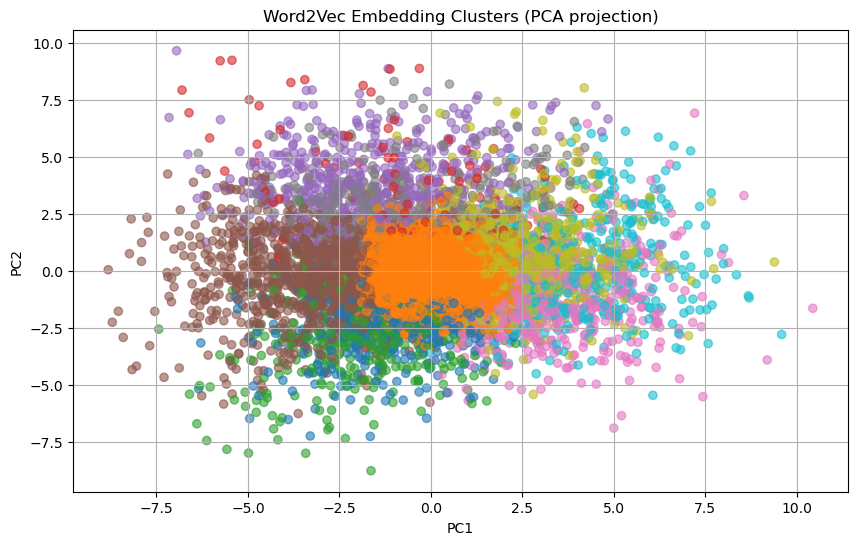

In [58]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("Word2Vec Embedding Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [59]:
# sort and preview words by cluster
for i in range(NUM_CLUSTERS):
    words = clusters_df[clusters_df["cluster"] == i]["word"].tolist()
    print(f"\nCluster {i}:")
    print(", ".join(words[:15]))  # show top 15


Cluster 0:
call, book, read, country, church, general, story, school, town, study, note, judge, address, public, service

Cluster 1:
fine, carry, clear, instead, music, line, remark, save, serve, plain, suggest, one, single, wonderful, remind

Cluster 2:
woman, child, wife, god, bear, daughter, son, soul, law, lord, human, death, age, land, teach

Cluster 3:
lydgate, tulliver, casaubon, bulstrode, brooke, heathcliff, weston, march, darcy, linton, elton, rochester, knightley, glegg, fairfax

Cluster 4:
say, mr, come, think, know, little, good, go, mrs, time, day, thing, see, tell, great

Cluster 5:
man, life, mind, world, high, manner, reason, sense, nature, idea, power, true, strong, state, character

Cluster 6:
walk, night, light, door, air, near, window, water, beautiful, foot, tree, reach, step, sound, dark

Cluster 7:
feel, love, turn, word, heart, maggie, moment, pass, feeling, thought, fall, voice, dorothea, rise, spirit

Cluster 8:
like, old, get, tom, cry, laugh, boy, run, set


**What worked well:**
- Certain clusters captured coherent themes, such as:
  - **Religious or familial roles** (`woman, god, child, soul`)
  - **Character groupings** (`dorothea, rochester, lydgate`)
  - **Emotional or perceptual states** (`feel, heart, love, moment`)

**What could improve:**
- Some clusters contained high-frequency but low-informative terms (`say`, `come`, `get`)
- The PCA projection was too dense, making visual interpretation difficult
- Analogy tasks were weak, likely due to the narrow literary domain and modest corpus size

**Next steps:**
- Re-train with a higher `min_count` and `window` to filter noise
- Use **UMAP** instead of PCA for clearer visual separation
- Focus on similarity and clustering over analogy performance

In [71]:
# updated hyperparameters to reduce noise and expand context
w2v_updated_model = Word2Vec(
    sentences=tokenized_chunks,
    vector_size=150,
    window=7,
    min_count=10,
    workers=4,
    epochs=30,
    seed=42
)

# re-extract word vectors and vocabulary
word_vectors_updated = w2v_updated_model.wv
vocab_updated = word_vectors_updated.index_to_key
X_updated= word_vectors_updated[vocab_updated]

In [72]:
# re-cluster
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_updated)

clusters_df_updated = pd.DataFrame({"word": vocab_updated, "cluster": labels})

In [73]:
# try UMAP
from umap import UMAP

umap_model = UMAP(n_components=2, random_state=42)
reduced_umap = umap_model.fit_transform(X)

/Users/emmamora/anaconda3/envs/feminist-nlp/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


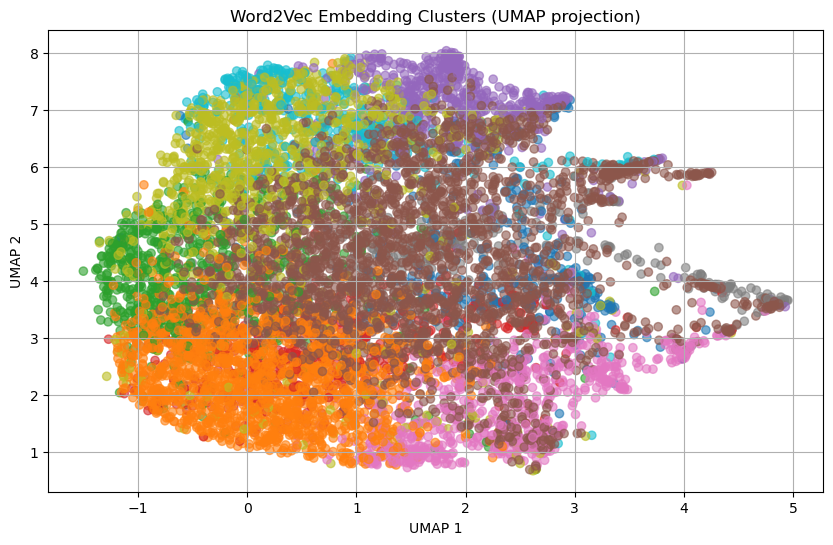

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("Word2Vec Embedding Clusters (UMAP projection)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

In [75]:
# print words by cluster
for i in range(10):
    words = clusters_df_updated[clusters_df_updated["cluster"] == i]["word"].tolist()
    print(f"\nCluster {i}:")
    print(", ".join(words[:15]))


Cluster 0:
mr, come, go, mrs, time, day, see, long, leave, miss, room, sit, house, home, place

Cluster 1:
high, nature, power, true, form, show, body, human, truth, beauty, virtue, sex, creature, free, effect

Cluster 2:
feel, life, love, heart, maggie, moment, god, feeling, thought, bear, sense, dorothea, spirit, strong, soul

Cluster 3:
man, great, mind, give, work, friend, world, wife, live, husband, far, family, present, manner, reason

Cluster 4:
hand, eye, face, head, arm, draw, small, table, large, white, dress, lay, amy, chair, hair

Cluster 5:
new, call, hold, appear, fine, carry, story, fair, line, second, dead, save, plain, command, part

Cluster 6:
woman, year, book, son, country, law, lord, church, age, land, unto, king, chapter, bible, history

Cluster 7:
say, think, know, like, look, little, good, thing, tell, find, take, old, way, shall, child

Cluster 8:
air, grow, beautiful, clear, touch, picture, fill, earth, thy, sweet, music, strike, bright, warm, heaven

Cluster

We retrained the Word2Vec model and applied UMAP for dimensionality reduction, producing a refined spatial visualization of word embeddings. The clustering is clearer and captures both stylistic functions and deep semantic groupings.

**Selected cluster interpretations:**

- **Cluster 0:** Social interaction and domestic presence — `mr, mrs, sit, room, home, place`
- **Cluster 1:** Moral philosophy and abstract traits — `virtue, beauty, truth, form, sex`
- **Cluster 2:** Emotion and internal states — `love, life, heart, soul, god, dorothea`
- **Cluster 3:** Social structure and gendered roles — `man, husband, wife, mind, family, reason`
- **Cluster 4:** Embodied physicality — `eye, hand, face, arm, dress, amy`
- **Cluster 5:** Events and narrative flow — `call, appear, dead, story, save, second`
- **Cluster 6:** Institutions and doctrine — `woman, church, lord, law, king, bible`
- **Cluster 7:** General utility verbs — `say, think, find, know, shall, child, old`
- **Cluster 8:** Romantic/aesthetic imagery — `sweet, air, music, warm, earth, heaven`
- **Cluster 9:** Movement and setting — `door, run, watch, water, window, fall`

These clusters reveal how literary language in feminist texts blends **narrative, affect, morality, and ideology**. The embedding structure can now support:
- Thematic filtering or lexicon expansion
- Emotion mapping
- Author-level lexical comparison

In [79]:
# save model
w2v_updated_model.save(str(REPO_DIR / "models" /"word2vec_feminist.model"))

# save clusters and UMAP results
umap_df = pd.DataFrame(reduced_umap, columns=["UMAP1", "UMAP2"])
umap_df["word"] = clusters_df["word"]
umap_df["cluster"] = clusters_df["cluster"]
umap_df.to_csv(PROCESSED_DIR / "word2vec_umap_clustered.csv", index=False)


### 5.4 BERTopic Modeling

We apply **BERTopic** to uncover latent themes in feminist literary texts by combining contextual sentence embeddings with topic clustering. The pipeline evolved through three stages to progressively reduce noise and focus on meaningful concepts.

1. **BERTopic on Raw Chunks**
- **Input:** `lemmatized_text` column from chunked dataset  
- **Model:** `all-MiniLM-L6-v2` sentence transformer
- BERTopic identified **22 topics**
- Many clusters were **dominated by character names** like `emma`, `jo`, `heathcliff`
- Frequent filler terms (*say*, *come*, *know*) diluted interpretability
- **Limitation:** Raw text retained narrative markers and named entities that overwhelmed thematic signals.

2. **BERTopic with NER Filtering**
- **Improvement:** Used `spaCy` to remove:
  - Named entities (especially `PERSON`)
  - Stopwords and common weak terms
- **Result:**  
  - Some reduction in character noise
  - However, bigram merging and missed detections allowed **names to leak back in**
  - Topics like `mr_darcy`, `emma` still dominated clusters

3. **BERTopic with Manual Name Filtering**
- **Enhancement:**
  - Extracted top ~50 character names from full text using `spaCy` + frequency filtering
  - Built a custom stopword list and removed these names
  - Re-applied BERTopic on the cleaned `filtered_text_no_names`
- **Outcome:**  
  - ~39 clean, **thematically coherent topics**
  - Topics centered on abstract feminist values (*virtue*, *freedom*, *mind*, *law*) instead of plot or people

**Summary of Results**

| Step                 | Topics Found | Notes                                                   |
|----------------------|--------------|----------------------------------------------------------|
| Raw BERTopic         | 22           | Character-heavy, redundant topics                        |
| With NER Filtering   | ~45          | Partial improvement, names still prominent               |
| With Name Filtering  | ~39          | Most interpretable: fewer names, clearer abstract themes |


**Outputs**
- Topic assignments per chunk in `thematic_chunks_bertopic.csv`
- Visualizations:  
  - `bertopic_overview.html`  
  - `bertopic_filtered_overview.html`  
  - `bertopic_no_names_overview.html`
- Saved model: `bertopic_no_names_feminist`

These clusters can now be used for emotion-overlay, KWIC analysis, or cross-author comparisons.

#### BERTopic Raw

In [3]:
# load thematic chunk data
df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_bigram.csv")
texts = df["lemmatized_text"].tolist()

In [4]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

print("Loading embedding model...")
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # fast + decent quality
print("Model loaded")
# "paraphrase-MiniLM-L12-v2" (slower, slightly richer) as an alternative

print("Initializing BERTopic...")
topic_model = BERTopic(
    embedding_model=embedding_model,
    n_gram_range=(1, 2),             # 1–2 word phrases
    min_topic_size=20,               # how general or ganular topics should be (10-20 for small-medium datasets)
    calculate_probabilities=True
)

print("BERTopic initialized")

Loading embedding model...
Model loaded
Initializing BERTopic...
BERTopic initialized


In [5]:
# fit model
topics, probs = topic_model.fit_transform(texts)

In [6]:
# sanity checks
print("Number of Topics Found:", len(set(topics)))

# print top 10 topics
print("Top 10 Topics:")
for i in range(10):
    print(f"Topic {i}: {topic_model.get_topic(i)}")

# top words in topic 0
topic_model.get_topic(0)

Number of Topics Found: 22
Top 10 Topics:
Topic 0: [('woman', 0.015337970963428565), ('man', 0.014538632848967255), ('life', 0.011194744670662731), ('love', 0.009682279872319512), ('mind', 0.009536986479684689), ('heart', 0.007563383711559572), ('child', 0.007532034419411181), ('virtue', 0.006667176524020324), ('nature', 0.006445338826665534), ('reason', 0.0059720334878122245)]
Topic 1: [('jo', 0.03431485262707519), ('meg', 0.02215356723383473), ('laurie', 0.019831685346644853), ('amy', 0.019502363692351428), ('beth', 0.01743565983908629), ('little', 0.013064498522181613), ('like', 0.01227597696690885), ('look', 0.011623901966934207), ('good', 0.011344618031369592), ('come', 0.01065606134356963)]
Topic 2: [('emma', 0.031470298842505996), ('harriet', 0.020655026312461945), ('think', 0.015690971227431294), ('mr_knightley', 0.014672795034580867), ('know', 0.01305474399912907), ('mrs_weston', 0.012894130106264503), ('thing', 0.012682898915151246), ('mr_elton', 0.011584951493422358), ('say'

[('woman', 0.015337970963428565),
 ('man', 0.014538632848967255),
 ('life', 0.011194744670662731),
 ('love', 0.009682279872319512),
 ('mind', 0.009536986479684689),
 ('heart', 0.007563383711559572),
 ('child', 0.007532034419411181),
 ('virtue', 0.006667176524020324),
 ('nature', 0.006445338826665534),
 ('reason', 0.0059720334878122245)]

In [7]:
# add topics and probabilities to the original df
df["bertopic_topic"] = topics
df["bertopic_prob"] = probs.max(axis=1)  # highest prob per row

In [10]:
# topic overview
topic_model.visualize_topics()
fig = topic_model.visualize_topics()
fig.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_overview.html"))

We applied BERTopic to discover latent themes in lemmatized book chunks using contextual sentence embeddings (all-MiniLM-L6-v2). The model automatically clustered the data into 22 topics.

**Observations:**
- Character-Centric Topics Dominate: A significant number of topics are centered around character names (jo, elizabeth, emma, etc.), indicating BERTopic is capturing stylistic/person-based clusters.
- Recurrent Low-Value Terms: Words like say, think, look, and come appeared frequently, contributing little to thematic insights.
- Overlap in Topics: Topics 0 and 4 both revolve around abstract human traits (woman, love, life, mind, virtue), suggesting redundancy.

**Limitations:**
- Overemphasis on Named Entities: Names of characters skewed the topics toward book-specific entities rather than generalizable feminist themes.
- Need for Pre-filtering: Raw chunks, even lemmatized, still contain filler or domain-specific clutter.

#### BERTopic Filtered (Standard NER)

In [25]:
# load lemmatized chunks
df_updated = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

In [26]:
# remove named entities and low-content words 
def filter_entities_and_lowvalue(text):
    doc = nlp(text)
    return " ".join([
        token.text for token in doc
        if not token.ent_type_  # remove named entities
        and not token.is_stop
        and token.is_alpha
        and len(token.text) > 2
    ])

df_updated["filtered_text"] = df_updated["lemmatized_text"].progress_apply(filter_entities_and_lowvalue)

100%|██████████| 5407/5407 [01:57<00:00, 46.21it/s]


In [27]:
df_updated["filtered_text"].head(25)

0     write memory unfortunately bring material care...
1     thing chance join big scientific expedition ne...
2     understand red blue pencil carry ask yes point...
3     glass squat investigate chemical sort tell spo...
4     dozen montenegroe great range discuss hotly wa...
5     cliff waterfall yes ask way course valuable lo...
6     find extremely clear idea country woman like u...
7     friend terry idea pretty woman game homely wor...
8     good speed cross base leave high mountain lake...
9     hold peace long run upward gosh terry woman ch...
10    progress talk civilization cry softly restrain...
11    scatter time reach far man dare push leave mai...
12    pleasant nearer sit learn language terry prote...
13    hear vanish gay laughter fleet away wide open ...
14    double row tree shade footpath tree vine fruit...
15    park open square college building stand quiet ...
16    woman earth brief address include partner ente...
17    evidently determine purpose apparently abl

In [28]:
# compare original vs filtered text side by side
df_updated[["lemmatized_text", "filtered_text"]].sample(5, random_state=42)

,lemmatized_text,filtered_text
4269,sprague surgeon director arrive early mr bulst...,sprague surgeon director arrive early bulstrod...
1615,justly selfish domineering end circumstance ca...,justly selfish domineering end circumstance ca...
1924,plump firm hand hold thin feeble one sound ple...,plump firm hand hold thin feeble sound pleasan...
230,mean helen laugh benignantly strew handful lon...,mean helen laugh benignantly strew handful lon...
465,light worship god spirit find conduct degree r...,light worship god spirit find conduct degree r...


In [29]:
# remove common weak verbs/adjectives (to focus on content-rich words)
weak_words = set(["say", "know", "come", "look", "think", "good", "thing", "make"])
df_updated["filtered_text"] = df_updated["filtered_text"].apply(
    lambda text: " ".join([w for w in text.split() if w not in weak_words])
)

In [33]:
# load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# initialize new topic model
topic_model_filtered = BERTopic(
    embedding_model=embedding_model,
    n_gram_range=(1, 2),
    min_topic_size=15,
    calculate_probabilities=True,
    verbose=True
)

# fit new model
topics_filtered, probs_filtered = topic_model_filtered.fit_transform(df_updated["filtered_text"])
df_updated["bertopic_topic_filtered"] = topics_filtered

2025-06-01 02:37:36,138 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 169/169 [00:31<00:00,  5.34it/s]
2025-06-01 02:38:08,011 - BERTopic - Embedding - Completed ✓
2025-06-01 02:38:08,011 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-01 02:38:10,572 - BERTopic - Dimensionality - Completed ✓
2025-06-01 02:38:10,573 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-01 02:38:10,863 - BERTopic - Cluster - Completed ✓
2025-06-01 02:38:10,872 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-01 02:38:13,796 - BERTopic - Representation - Completed ✓


In [35]:
# sanity checks
print("Number of Filtered Topics Found:", len(set(topics_filtered)))

# print top 10 topics
print("Top 10 Filtered Topics:")
for i in range(10):
    print(f"Topic {i}: {topic_model_filtered.get_topic(i)}")

# top words in topic 0
topic_model_filtered.get_topic(0)

Number of Filtered Topics Found: 27
Top 10 Filtered Topics:
Topic 0: [('emma', 0.018012990926493538), ('miss', 0.016048426708830534), ('mrs', 0.014700011554385078), ('jane', 0.011485498772989461), ('harriet', 0.01110234832927834), ('weston', 0.010836195345389018), ('darcy', 0.010282088824897858), ('elton', 0.010142892258729466), ('soon', 0.009758409282780241), ('bennet', 0.009544223820669927)]
Topic 1: [('maggie', 0.041957917754217484), ('tulliver', 0.025573637470859032), ('glegg', 0.016037606489321635), ('mrs', 0.0148012278772396), ('father', 0.013420383541993331), ('tom', 0.013267405706670014), ('philip', 0.012286240597968888), ('like', 0.011488865501697932), ('mrs tulliver', 0.01093675497501574), ('pullet', 0.009675258755908927)]
Topic 2: [('woman', 0.03548096281890804), ('unto', 0.02167665015477243), ('man', 0.01919210573793374), ('lord', 0.017932291582682374), ('bible', 0.015040046357131888), ('god', 0.014483234479548798), ('wife', 0.01448039622440218), ('king', 0.0136808454477936

[('emma', 0.018012990926493538),
 ('miss', 0.016048426708830534),
 ('mrs', 0.014700011554385078),
 ('jane', 0.011485498772989461),
 ('harriet', 0.01110234832927834),
 ('weston', 0.010836195345389018),
 ('darcy', 0.010282088824897858),
 ('elton', 0.010142892258729466),
 ('soon', 0.009758409282780241),
 ('bennet', 0.009544223820669927)]

In [37]:
# topic overview
topic_model_filtered.visualize_topics()
fig = topic_model_filtered.visualize_topics()
fig.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_filtered_overview.html"))

Even after running Named Entity Recognition (NER), many topic clusters include frequent character names such as `emma`, `dorothea`, or `heathcliff`. This happens due to several factors:
- **NER Limitations**: spaCy’s entity recognizer can miss literary or archaic names, especially if they are lowercased, abbreviated, or used in indirect ways.
- **Bigram Reintroduction**: Named bigrams like `mr_darcy` or `mrs_weston` are often constructed *after* NER filtering, allowing names to re-enter the token stream.
- **High Term Frequency**: Characters are central to narratives and frequently repeated. LDA and BERTopic pick up on this as strong thematic signals.
- **Model Behavior**: Topic models are unsupervised and optimize for *co-occurrence patterns*, not semantic categories like "name" vs. "concept".

To reduce unwanted name-dominance in topic clusters, we could consider:
- Adding **common character names** to a custom stopword list.
- Applying **NER before** bigram/collocation detection to prevent reintroduction.
- Using **TF-IDF filtering** to remove globally frequent tokens.
- Post-processing topics to **prune or merge** name-heavy clusters if not thematically meaningful.

This preserves interpretability while shifting focus to more abstract or thematic patterns like `virtue`, `work`, or `freedom`.

For the sake of brevity, we will just remove common character names.

#### BERTopic Filtered (Name Filtering)

In [38]:
from collections import Counter

# combine all lemmatized chunks (or raw if more accurate)
all_text = " ".join(df_updated["chunk"].tolist())

# process in smaller batches to avoid memory issues
def extract_person_entities(text, batch_size=10000):
    people = []
    for i in tqdm(range(0, len(text), batch_size)):
        doc = nlp(text[i:i+batch_size])
        people.extend([ent.text.lower() for ent in doc.ents if ent.label_ == "PERSON"])
    return people

# run entity extraction
character_entities = extract_person_entities(all_text)

# count frequencies
char_counts = Counter(character_entities)

100%|██████████| 1455/1455 [05:46<00:00,  4.20it/s]


In [87]:
df_characters = pd.DataFrame(character_entities, columns=["character"])
df_characters.to_csv(str(PROCESSED_DIR / "character_list.csv"))

In [89]:
# preview most common names
char_counts.most_common(10)

[('tom', 2012),
 ('jo', 1370),
 ('dorothea', 1041),
 ('emma', 903),
 ('jane', 873),
 ('elizabeth', 812),
 ('mary', 737),
 ('amy', 710),
 ('casaubon', 702),
 ('laurie', 657)]

In [40]:
# frequency cutoff >50
name_list = [name for name, count in char_counts.items() if count > 50]

In [41]:
# load lemmatized chunks
df_updated = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

# remove named entities and low-content words 
def filter_entities_and_lowvalue(text):
    doc = nlp(text)
    return " ".join([
        token.text for token in doc
        if not token.ent_type_  # remove named entities
        and not token.is_stop
        and token.is_alpha
        and len(token.text) > 2
    ])

df_updated["filtered_text"] = df_updated["lemmatized_text"].progress_apply(filter_entities_and_lowvalue)

# remove common weak verbs/adjectives (to focus on content-rich words)
weak_words = set(["say", "know", "come", "look", "think", "good", "thing", "make"])
df_updated["filtered_text"] = df_updated["filtered_text"].apply(
    lambda text: " ".join([w for w in text.split() if w not in weak_words])
)

# remove character names from the filtered text
df_updated["filtered_text_no_names"] = df_updated["filtered_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in name_list])
)
# check if names were removed
print("Sample filtered text without names:")
print(df_updated["filtered_text_no_names"].sample(5, random_state=42).tolist())

100%|██████████| 5407/5407 [01:58<00:00, 45.64it/s]


Sample filtered text without names:
['sprague surgeon director arrive early treasurer chairman absent conversation imply issue problematical majority tyke certain generally suppose physician wonder turn unanimous different mind concur action rugged weighty foresee adherent doctor suspect religion middlemarch tolerate deficiency probable professional weight believe world old association cleverness evil principle potent mind lady patient strict idea frilling sentiment negation doctor neighbor hard head dry witted condition texture hold favorable storing judgment connect drug event certain medical man middlemarch reputation definite religious view prayer active piety general presumption medical skill ground professionally speak fortunate religious sympathy general kind distant medical sanction sentiment church dissent adhesion particular tenet insist apt lutheran doctrine justification church stand fall return sure man mere machine fortuitous conjunction atom mrs wimple insist particular 

In [46]:
# rerun topic modeling without character names
# load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# initialize new topic model
topic_model_filtered = BERTopic(
    embedding_model=embedding_model,
    n_gram_range=(1, 2),
    min_topic_size=12, # size 10 => 45 topics; size 15 => 3 topics; 12 => 39 topics; 13 => 3 topics (sudden dip due to HDBSCAN sensitivity, clutter collapse, etc.)
    calculate_probabilities=True,
    verbose=True
)

# fit new model
topics_filtered, probs_filtered = topic_model_filtered.fit_transform(df_updated["filtered_text_no_names"])
df_updated["bertopic_topic_filtered_no_names"] = topics_filtered

# sanity checks
print("Number of Filtered Topics Found (No Names):", len(set(topics_filtered)))

# print top 10 topics
print("Top 10 Filtered Topics (No Names):")
for i in range(10):
    print(f"Topic {i}: {topic_model_filtered.get_topic(i)}")

# top words in topic 0
topic_model_filtered.get_topic(0)

2025-06-01 03:17:20,198 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s]
2025-06-01 03:17:53,669 - BERTopic - Embedding - Completed ✓
2025-06-01 03:17:53,672 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-01 03:17:58,210 - BERTopic - Dimensionality - Completed ✓
2025-06-01 03:17:58,216 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-01 03:17:58,663 - BERTopic - Cluster - Completed ✓
2025-06-01 03:17:58,683 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-01 03:18:02,214 - BERTopic - Representation - Completed ✓


Number of Filtered Topics Found (No Names): 39
Top 10 Filtered Topics (No Names):
Topic 0: [('mrs', 0.014993117771097965), ('dear', 0.009453551791171043), ('soon', 0.00922424784730345), ('friend', 0.008417135719154928), ('time', 0.008094082182478616), ('sister', 0.008028998492859233), ('hope', 0.007851718853020596), ('wish', 0.007681811359678398), ('lady', 0.0076581984639002895), ('hear', 0.007329460488691415)]
Topic 1: [('woman', 0.021199199018099614), ('man', 0.017545776062343175), ('virtue', 0.010754140650672487), ('mind', 0.01034597790557232), ('child', 0.0095190381898665), ('sex', 0.009332420718252687), ('reason', 0.009022130408337282), ('life', 0.008675003308986523), ('love', 0.007786495287510211), ('nature', 0.00717985915301867)]
Topic 2: [('woman', 0.030464606000845468), ('unto', 0.02024820525339159), ('lord', 0.016964802617724095), ('man', 0.016139750412485228), ('bible', 0.014231021183600635), ('god', 0.013548864330346112), ('king', 0.013292640324314443), ('wife', 0.013133163

[('mrs', 0.014993117771097965),
 ('dear', 0.009453551791171043),
 ('soon', 0.00922424784730345),
 ('friend', 0.008417135719154928),
 ('time', 0.008094082182478616),
 ('sister', 0.008028998492859233),
 ('hope', 0.007851718853020596),
 ('wish', 0.007681811359678398),
 ('lady', 0.0076581984639002895),
 ('hear', 0.007329460488691415)]

In [47]:
# topic overview
topic_model_filtered.visualize_topics()
fig_1 = topic_model_filtered.visualize_topics()
fig_1.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_no_names_overview.html"))

In [51]:
# topic similarity heatmap
fig_2 = topic_model_filtered.visualize_heatmap()
fig_2.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_no_names_heatmap.html"))

In [52]:
# save results
topic_model_filtered.save(str(REPO_DIR / "models" / "bertopic_no_names_feminist"))
df_updated.to_csv(PROCESSED_DIR / "thematic_chunks_bertopic.csv", index=False)

2025-06-01 03:22:53,779 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


### 5.5 KWIC

To explore how core feminist concepts were used in context, we performed KWIC extraction across all book chunks. Keywords (25) were grouped into categories like marriage, labor, independence, and emotion.

We visualized:
- **Keyword frequency overall**
- **Keyword frequency by author**
- **Keyword co-occurrence in KWIC contexts**

This method surfaces *where* and *how* key themes appear in the literature, forming a bridge between text and topic model interpretation. It also primes us for the next step: exploring **emotional tone and sentiment**.

In [54]:
# define keyword-in-context (KWIC) extraction function
def extract_kwic(text, keyword, window=10):
    tokens = text.split()
    matches = []
    for i, token in enumerate(tokens):
        if token == keyword:
            start = max(0, i - window)
            end = min(len(tokens), i + window + 1)
            kwic_window = tokens[start:end]
            matches.append(" ".join(kwic_window))
    return matches

In [55]:
# load processed thematic chunks with BERTopic results
df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_bertopic.csv")
tqdm.pandas()

# define thematic keywords (can refine further)
theme_terms = [
    "marriage", "husband", "wife", "divorce", "matrimony", "union",
    "independence", "education", "school", "reason", "freedom", "rights",
    "work", "labor", "money", "employment", "poverty", "job", "career",
    "love", "feel", "care", "heart", "mother", "father", "child", "girl", "boy",
    "virtue", "power", "obey", "duty", "truth", "law", "voice", "vote"
]

# make a lowercase version of the raw chunk text for matching
df["chunk_lower"] = df["chunk"].str.lower()

# initialize list to collect kwic data
kwic_records = []

# define a function to extract KWIC (± window_size words)
def extract_kwic(text, keyword, window_size=5):
    tokens = text.split()
    matches = []
    for i, token in enumerate(tokens):
        if token == keyword:
            start = max(i - window_size, 0)
            end = min(i + window_size + 1, len(tokens))
            matches.append(" ".join(tokens[start:end]))
    return matches

# loop through each thematic keyword and collect context windows
for term in theme_terms:
    for _, row in df.iterrows():
        chunk_text = row["chunk_lower"]  # match on lowercase version
        windows = extract_kwic(chunk_text, term)
        for context in windows:
            kwic_records.append({
                "keyword": term,
                "context": context,
                "title": row["title"],
                "author": row["author"],
                "topic": row.get("bertopic_topic_filtered_no_names", None)
            })

# convert to dataframe
kwic_df = pd.DataFrame(kwic_records)

In [57]:
# save to CSV
kwic_df.to_csv(PROCESSED_DIR / "kwic_theme_terms.csv", index=False)
# display
kwic_df

,keyword,context,title,author,topic
0,marriage,"a strange, new joy. of marriage as a ceremony ...",Herland,Charlotte Perkins Gilman,-1
1,marriage,new joy. of marriage as a ceremony they knew,Herland,Charlotte Perkins Gilman,1
2,marriage,“of course they haven’t any marriage ceremony ...,Herland,Charlotte Perkins Gilman,1
3,marriage,"are monogamous, you know. and marriage is the ...",Herland,Charlotte Perkins Gilman,-1
4,marriage,with them and made our marriage vows. chapter ...,Herland,Charlotte Perkins Gilman,1
...,...,...,...,...,...
15132,vote,that. when i give a vote i must know what i,Middlemarch,George Eliot,-1
15133,vote,that away; else i should vote for things stayi...,Middlemarch,George Eliot,-1
15134,vote,that away; else i should vote for things stayi...,Middlemarch,George Eliot,-1
15135,vote,"would not withdraw from me, vote or no vote, w...",Middlemarch,George Eliot,-1


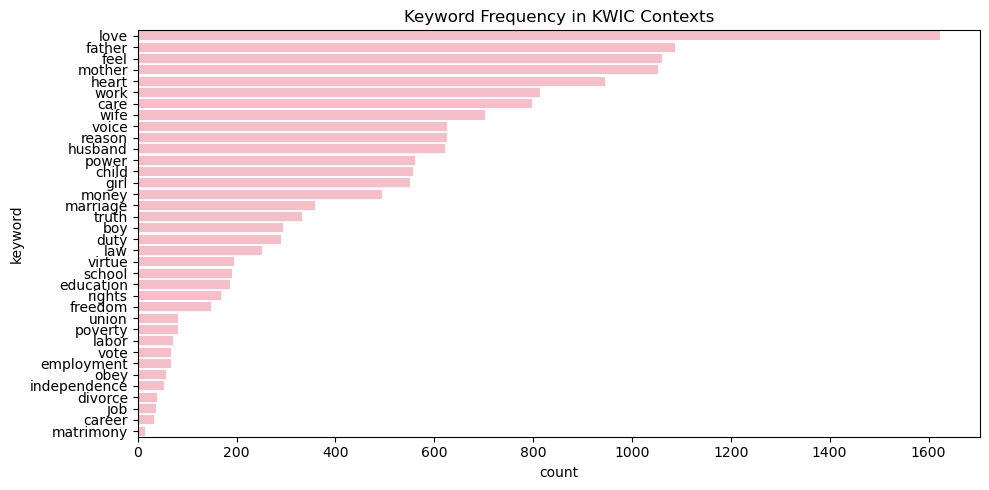

In [64]:
# keyword frequency distribution
plt.figure(figsize=(10, 5))
sns.countplot(
    data=kwic_df,
    y="keyword", 
    order=kwic_df["keyword"].value_counts().index, 
    color="lightpink"
    )
plt.title("Keyword Frequency in KWIC Contexts")
plt.tight_layout()
plt.show()

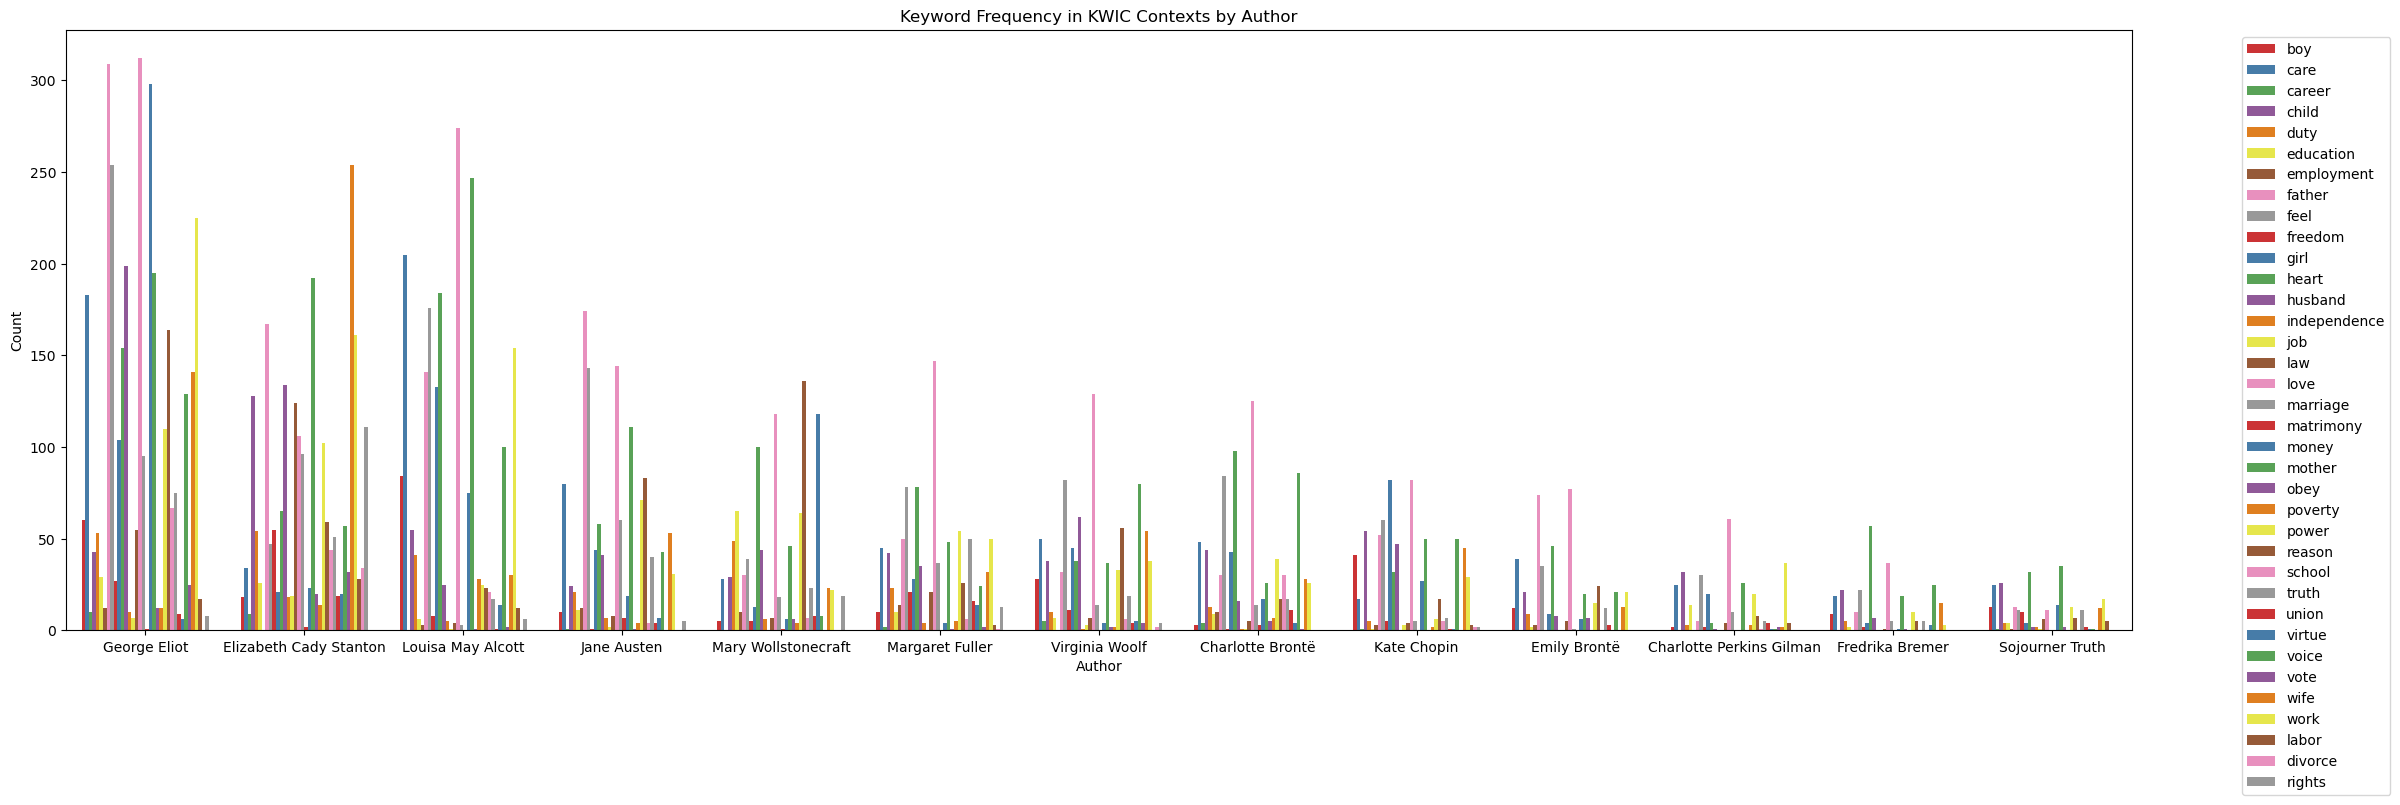

In [70]:
# analysis of keyword mentions by author

# aggregate keyword counts by author
keyword_counts = kwic_df.groupby(["author", "keyword"]).size().reset_index(name="count")

# sort authors by total keyword mentions (optional, for nicer layout)
author_order = (
    keyword_counts.groupby("author")["count"]
    .sum()
    .sort_values(ascending=False)
    .index
)

# plot as grouped bar chart
plt.figure(figsize=(24, 8))
sns.barplot(
    data=keyword_counts,
    x="author",
    y="count",
    hue="keyword",
    order=author_order,
    palette="Set1"
)
plt.title("Keyword Frequency in KWIC Contexts by Author")
plt.xlabel("Author")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This first visualization aggregates the total frequency of each thematic keyword across all KWIC (Keyword-in-Context) occurrences per author. This bar plot enables a high-level comparison of how often different themes - like **marriage**, **freedom**, or **work** - appear in the writing of each author.

**Some Findings:**
- **George Eliot**, **Louisa May Alcott**, and **Elizabeth Cady Stanton** emerge as the most thematically dense authors
- Emotion- or family-centered terms (e.g., `heart`, `mother`, `child`) dominate across authors, while more socio-political terms like `vote`, `career`, or `labor` are rarer
- This plot helps identify thematic emphasis at the corpus level

Text(0.5, 0.98, 'Keyword Frequency by Author (KWIC Contexts)')

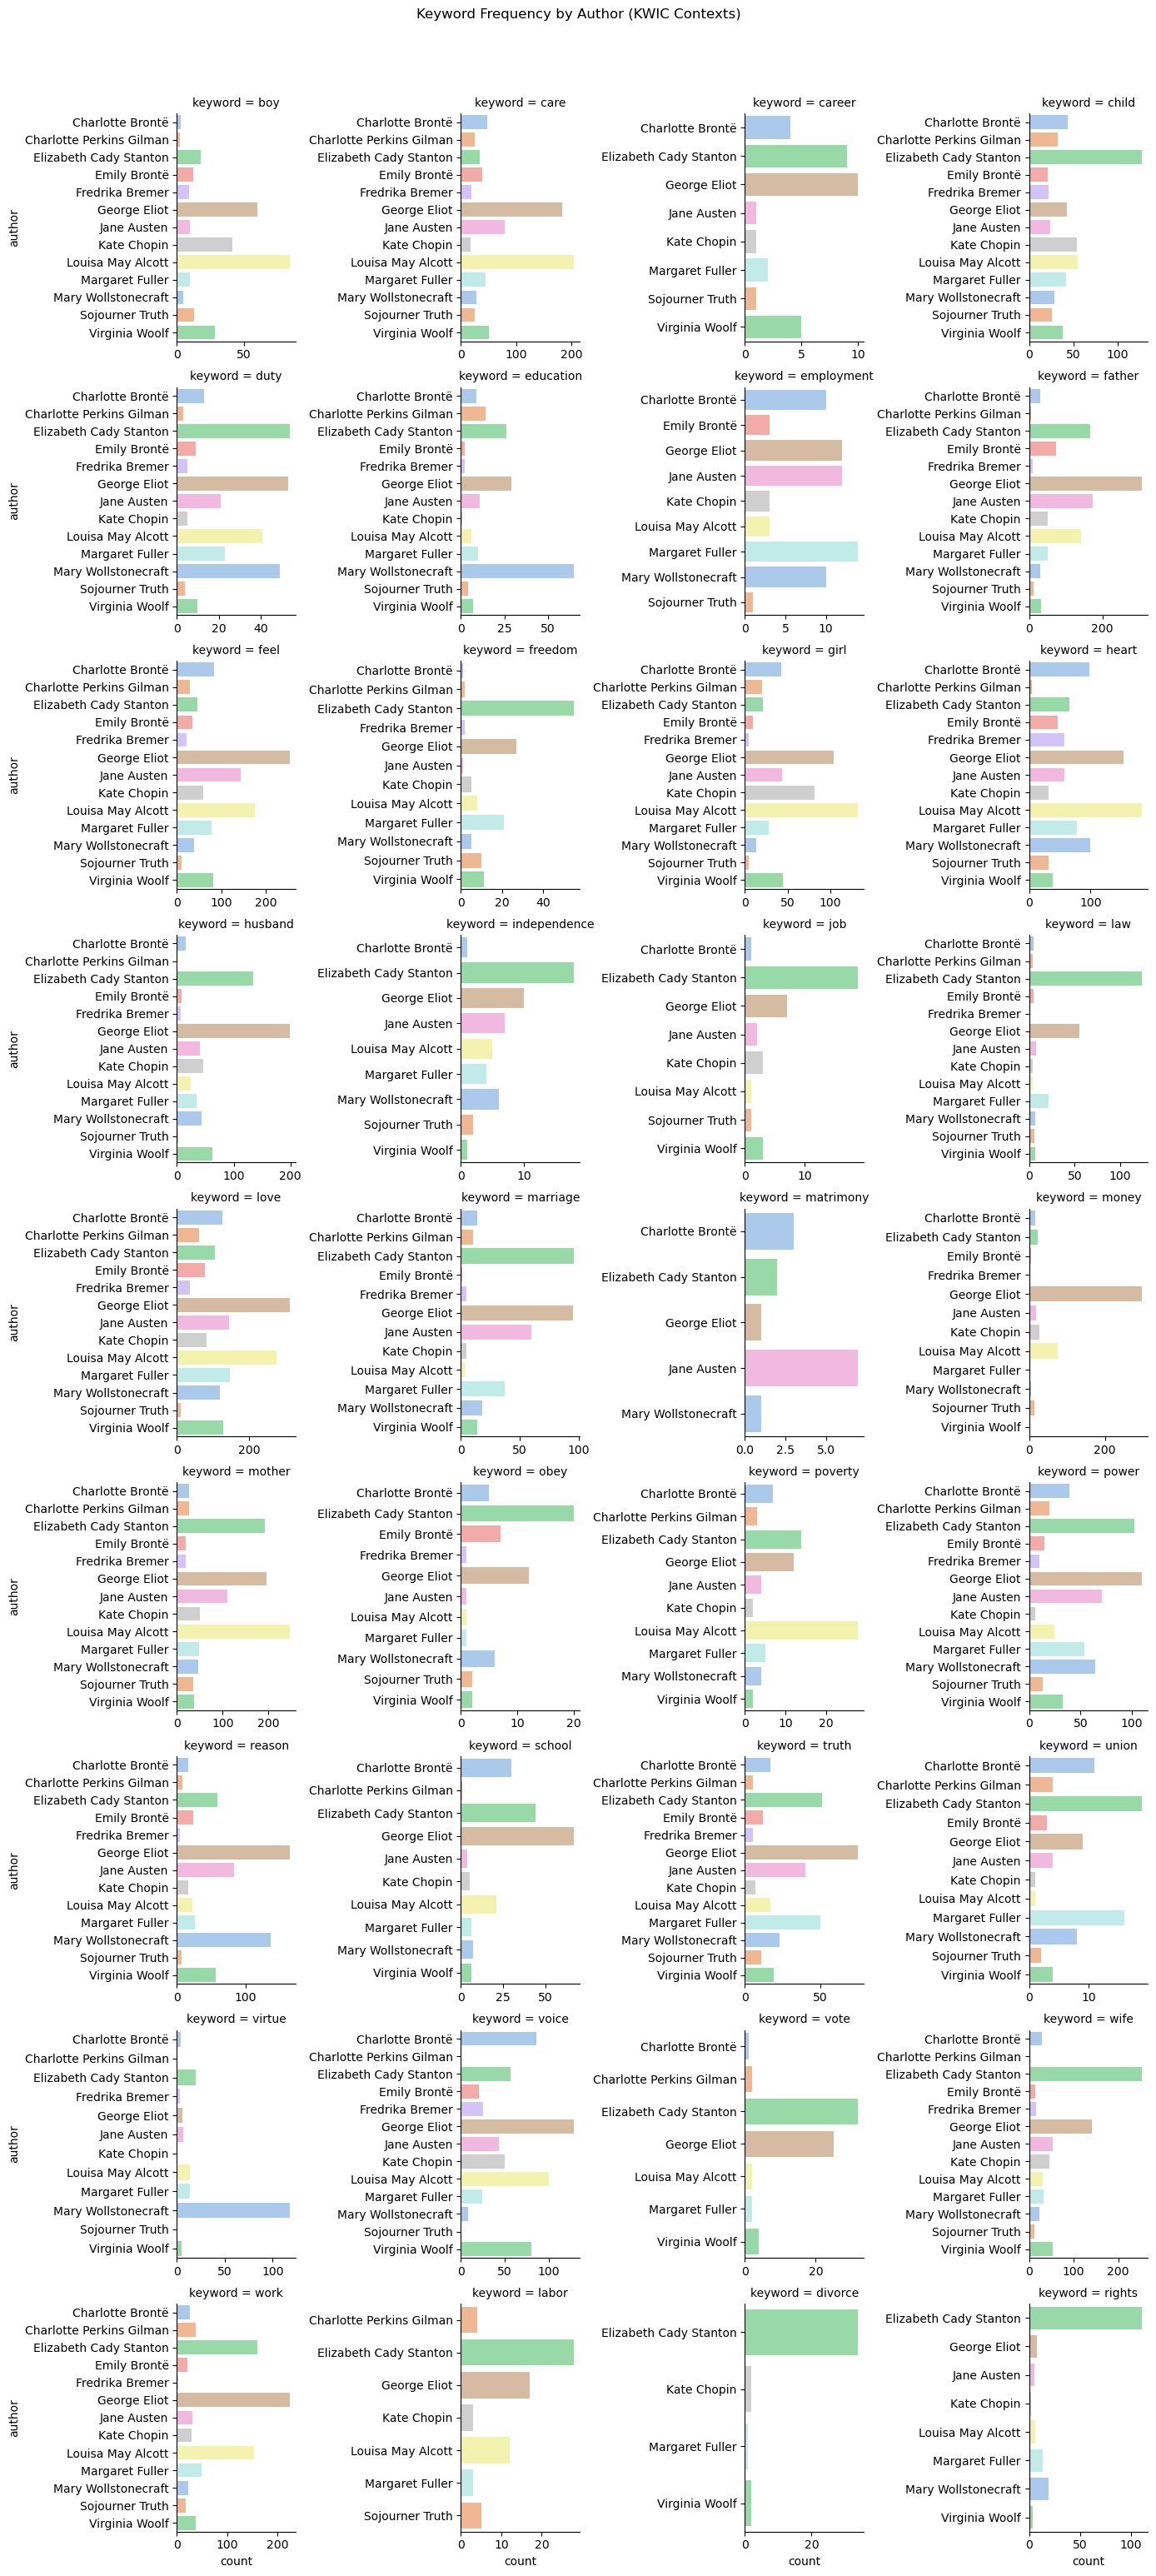

In [75]:
# analysis of author distribution for each keyword
g = sns.catplot(
    data=keyword_counts,
    kind="bar",
    x="count", y="author",
    col="keyword",
    col_wrap=4,
    height=3.5,
    sharex=False,
    sharey=False,
    palette="pastel"
)
g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Keyword Frequency by Author (KWIC Contexts)")

The second plot breaks down frequency by **each individual keyword**, shown in separate subplots, offering fine-grained insight into which authors discuss which terms most.

- For instance, **Elizabeth Cady Stanton** frequently uses terms like `vote`, `rights`, and `law`, consistent with her activist writing
- **Mary Wollstonecraft** heavily emphasizes `virtue`, `reason`, and `obedience`, aligning with Enlightenment discourse
- **Louisa May Alcott** and **Jane Austen** show strong emphasis on `marriage`, `love`, and `mother`, reinforcing family and relational themes

This breakdown allows us to compare how feminist concerns shift between **moral-philosophical**, **domestic**, and **political** domains across time and authorship.

In [76]:
# show KWIC contexts for selected keywords
sample_terms = ["marriage", "independence", "work", "love", "vote"]
for term in sample_terms:
    print(f"\n--- KWIC for: {term.upper()} ---")
    display(kwic_df[kwic_df["keyword"] == term][["context", "author", "title"]].sample(5, random_state=42))


--- KWIC for: MARRIAGE ---


,context,author,title
223,thousand pounds was settled by marriage articl...,Jane Austen,Pride and Prejudice
42,that the children of the marriage should be br...,Elizabeth Cady Stanton,The Woman's Bible
261,boudoir—with a background of prospective marri...,George Eliot,Middlemarch
301,i will hinder! such a marriage would be fatal ...,George Eliot,Middlemarch
56,marriage. the pythagoreans taught that marriag...,Elizabeth Cady Stanton,The Woman's Bible



--- KWIC for: INDEPENDENCE ---


,context,author,title
1835,"tremulous, had a certain proud independence in...",George Eliot,The Mill on the Floss
1865,"will, still nettled. “my personal independence...",George Eliot,Middlemarch
1864,with his unmixed resolutions of independence a...,George Eliot,Middlemarch
1828,"that an external freedom, an independence of t...",Margaret Fuller,Woman in the Nineteenth Century
1860,a sense of power and independence better than ...,Louisa May Alcott,Little Women



--- KWIC for: WORK ---


,context,author,title
3435,"(a strange comment theirs, when work was done)...",Virginia Woolf,Mrs Dalloway
3777,"you like. i intend to work hard,” said amy in her",Louisa May Alcott,Little Women
3415,existing.) meals are taken separately; work is...,Margaret Fuller,Woman in the Nineteenth Century
3479,them alone they'd go to work and take care of ...,Louisa May Alcott,An Old-Fashioned Girl
3727,plainly showed how earnest her work had been. ...,Louisa May Alcott,Little Women



--- KWIC for: LOVE ---


,context,author,title
4922,"st. john said, it was love that made her under...",Virginia Woolf,The Voyage Out
5268,"so much, and seems to love so well! but--the n...",Fredrika Bremer,Strife and Peace
5623,way; that i’m mad with love for you; that i re...,George Eliot,The Mill on the Floss
6013,an effort and tried to love him. it couldn’t b...,Louisa May Alcott,Little Women
5416,but i own i should love well to bring her pride,Emily Brontë,Wuthering Heights



--- KWIC for: VOTE ---


,context,author,title
15115,"convenient side, and given his vote for the ap...",George Eliot,Middlemarch
15085,"platform, address the assembly, or vote for me...",Elizabeth Cady Stanton,Eighty Years and More
15073,as to think that a vote does him or her any,Virginia Woolf,The Voyage Out
15078,"was then adopted by a vote of 53 to 41. ""the",Elizabeth Cady Stanton,The Woman's Bible
15097,say her prayers. our women vote with the same ...,Elizabeth Cady Stanton,Eighty Years and More


In [77]:
# save KWIC results to CSV
kwic_df.to_csv(PROCESSED_DIR / "kwic_results.csv", index=False)

## 6. Emotion and Tone Classification

## 7. Vizualizations

### 🧠 Why Are Some LDA Topics Book-Specific While Others Are Thematic?

In the LDA output, we observe a mix of:

- **Book-specific topics** (e.g., Topic 3 → *Middlemarch*, Topic 7 → *Little Women*)
- **Cross-book thematic topics** (e.g., Topic 4 → love/virtue, Topic 9 → womanhood/religion)

This emerges because LDA is an **unsupervised model** that clusters words based on co-occurrence patterns across documents.

#### 🔹 Why Book-Specific Topics Emerge:
- **Named entities dominate**: Characters like *Dorothea*, *Lydgate*, *Jo*, *Polly*, etc., are unique to one book.
- **Unique vocabulary**: Authors often invent or favor specific idioms, especially in tightly focused narratives.
- **Stylistic or structural isolation**: Books that differ in tone, voice, or genre naturally produce distinct lexical patterns.

These topics are often **highly coherent**, but **not generalizable** — they "overfit" to one literary world (which is expected).

#### 🔸 Why Thematic Topics Cross Books:
- These capture **common feminist concerns**: `virtue`, `mind`, `love`, `child`, `wife`, `god`.
- Such words appear in **many different works**, often framed differently (e.g., *Wollstonecraft* vs. *Stanton*).
- These topics reflect **shared cultural or ideological ground** across the corpus.

These are the most useful for:
- Comparing authors’ approaches to shared themes
- Aligning with external lexicons or emotion models
- KWIC or sentiment overlays

#### ✅ Conclusion:
LDA naturally surfaces both **local (book-specific)** and **global (corpus-wide)** topics. Both are valuable:
- Local topics reflect narrative and character identity.
- Global topics capture recurring thematic structure across feminist literature.